In [1]:
##### Import libraries and define helper functions
#import ipy_autoreload
# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2
%config IPCompleter.greedy=True
###### fix notebook theme: make cells wide and add a margin to output cells
from IPython.core.display import display, HTML
display(HTML("""
<style>
  .container { width:99% !important; } 
  div.cell{
    width:100%;
    margin-left:1%;
    margin-right:auto;
  }
  div.output_area {
   display: -webkit-box;
   padding: 13px;
  }
</style>"""))
#################################
import re
import time
import os
import sys, traceback
import gc
import numpy as np
#to dump objects
import cPickle as pickle
import operator

import matplotlib
#matplotlib.use('PDF')
#matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
import matplotlib as mpl
fm = mpl.font_manager
fm.get_cachedir()
from matplotlib import rc
#rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)
import pylab
from numpy.core.function_base import linspace
from numpy.lib.function_base import meshgrid
from numpy.core.numeric import array
from matplotlib import colors
from mpl_toolkits.mplot3d.axes3d import Axes3D
#from mpl_toolkits import mplot3d
from matplotlib.collections import LineCollection, PolyCollection
from matplotlib.colors import colorConverter

from matplotlib import cm
from collections import OrderedDict, Set

######################################################
#constants
experiment_time_stamp_idx=0
ble_mode_idx=1
tx_power_idx=2
tx_offset_idx=3
capture_idx=4
prr_1_idx=5
prr_2_idx=6
prr_ct_idx=7
rssi_avg_idx=8
rssi_stddev_idx=9
ts_delta_avg_idx=10
ts_delta_stddev_idx=11

#constatnts
Ble_1Mbit=3 #/*!< 1 Mbit/s Bluetooth Low Energy */
Ble_2Mbit=4 #/*!< 2 Mbit/s Bluetooth Low Energy */
Ble_LR125Kbit=5 #/*!< Long range 125 kbit/s (TX Only - RX supports both) */
Ble_LR500Kbit=6 #/*!< Long range 500 kbit/s (TX Only - RX supports both) */
IEER802154_250Kbit=15
ble_mode_str_list = ["1Mbps", "2Mbps", "LR-125Kbps", "LR-500Kbps", "IEEE 802.15.4"]
ble_mode_str_list_compact = ["1 M", "2 M", "125 K", "500 K", "802.15.4"]
blueFloodSlotSizes = {Ble_1Mbit:0.5325, Ble_2Mbit:0.3636, Ble_LR500Kbit:1.324, Ble_LR125Kbit:3.677, IEER802154_250Kbit:1.829}
#ble_mode_str_dict = {Ble_1Mbit: "1Mbps", Ble_2Mbit:"2Mbps", Ble_LR125Kbit:"LR-125Kbps", Ble_LR500Kbit:"LR-500Kbps"}
ble_mode_str_dict = {Ble_1Mbit: "1 M", Ble_2Mbit:"2 M", Ble_LR125Kbit:"125 K", Ble_LR500Kbit:"500 K", IEER802154_250Kbit:"802.15.4"}

def ble_mode_str(m):
  return ble_mode_str_list[m-3] if (m>=3 or m<=6) else ("RF Mode Unknown %d" %(m))

def ble_mode_str_compact(m):
  return ble_mode_str_list_compact[m-3] if (m>=3 or m<=6) else ("RF Mode Unknown %d" %(m))

plot_ts_delta_over = False
plot_rssi_diff_over = False

linestylesDict = OrderedDict(
    [('solid',               (0, ())),
     ('loosely dotted',      (0, (1, 10))),
     ('dotted',              (0, (1, 5))),
     ('densely dotted',      (0, (1, 1))),

     ('loosely dashed',      (0, (5, 10))),
     ('dashed',              (0, (5, 5))),
     ('densely dashed',      (0, (5, 1))),

     ('loosely dashdotted',  (0, (3, 10, 1, 10))),
     ('dashdotted',          (0, (3, 5, 1, 5))),
     ('densely dashdotted',  (0, (3, 1, 1, 1))),

     ('loosely dashdotdotted', (0, (3, 10, 1, 10, 1, 10))),
     ('dashdotdotted',         (0, (3, 5, 1, 5, 1, 5))),
     ('densely dashdotdotted', (0, (3, 1, 1, 1, 1, 1)))])
#linestyles = linestylesDict.items()
linestyles = ['-', '--', '-.', ':',linestylesDict['densely dotted']]
markers = ['o', '8', 's', 'p', '*', 'h', 'H', 'D', 'd', 'v', '^', '<', '>',]

def timing(f):
  def wrap(*args, **kwargs):
    time1 = time.time()
    ret = f(*args, **kwargs)
    time2 = time.time()
    print '%s function took %f ms' % (f.func_name, (time2-time1)*1000.0)
    return ret
  return wrap

def saveObject(userobj, filename):
    with open(filename, 'wb') as outputFile:
        pickle.dump(userobj, outputFile, pickle.HIGHEST_PROTOCOL)

def loadObject(filename):
    userobj = None
    with open(filename, 'rb') as inputFile:
        userobj = pickle.load(inputFile)
    return userobj

def tx_status_map_bad_rx(t):
  ''' 
  '-': rx ok
  '1': mote 1 tx
  '2': mote 2 tx
  'B': both tx
  ':': skipped slot
  ''' 
  if(t in ['-', '1', '2', 'B', ':', 'X', '\0']):
    return 0
  else:
    return 1

def tx_status_map_tx(t):
  ''' 
  '-': rx ok
  '1': mote 1 tx
  '2': mote 2 tx
  'B': both tx
  ':': skipped slot
  ''' 
  if(t in ['1', '2', 'B', 'X']):
    return 1
  else:
    return 0

def tx_status_map_tx2(t):
  ''' 
  '-': rx ok
  '1': mote 1 tx
  '2': mote 2 tx
  'B': both tx
  ':': skipped slot
  ''' 
  if(t in ['-', ':']):
    return 0
  elif(t in ['1', '2', 'B', 'X']):  
    return 1
  else:
    return 2

In [30]:
#### Functions to parse experiment logs, for Graz testbed
##############
#12345_2019_12_18_18_05_59_dirty-channel__ble_mode_6_txpower_4_txoffset_0_capture_0_packet_size_38_nch_3_och_0_ntx_4_i_0_testbed_GRAZ_TESTBED None
expname_regex = re.compile("(\d+)_(\d+)_(\d+)_(\d+)_(\d+)_(\d+)_(\d+)(?:_dirty-channel)?_?_ble_mode_(\d+)_txpower_(-?\d+)_txoffset_(-?\d+)_capture_(\d)(_packet_size_(\d+))?(_nch_(\d+))?(_och_(\d+))?(_ntx_(\d+))?(_i_(\d+))?(_testbed_(\w+)_TESTBED)?")
def parse_experiment_name(expname, nch=1, och=1, ntx=4, packet_size = 38):
  res = expname_regex.match(expname)
  #print dirname
  parsed = None
  if res:
    exp_number = int(res.group(1))
    ts = [int(res.group(2)), int(res.group(3)), int(res.group(4)), int(res.group(5)), int(res.group(6)),int(res.group(7))]
    ble_mode = int(res.group(8))
    txpower = int(res.group(9))
    txoffset = int(res.group(10))
    capture = int(res.group(11))
    initiator = None
    testbed = None
    if res.group(12):
        if str(res.group(12)).startswith("_packet_size_"):
            packet_size = int(res.group(13))
    if res.group(14):
        if str(res.group(14)).startswith("_nch_"):
            nch = int(res.group(15))
    if res.group(16):
        if str(res.group(16)).startswith("_och_"):
            och = int(res.group(17))
    if res.group(18):
        if str(res.group(18)).startswith("_ntx_"):
            ntx = int(res.group(19))
    if res.group(20):
        if str(res.group(20)).startswith("_i_"):
            initiator = int(res.group(21))       
    if res.group(22):
        if str(res.group(22)).startswith("_testbed_"):
            testbed = str(res.group(23))   
    parsed = [exp_number, ts, ble_mode, txpower, txoffset, capture, packet_size, nch, och, ntx, initiator, testbed]
  return parsed

#2019-12-19 00:32:53.102248|{tx-49} :B---AAAAAAAAAA...
#1574953250505373 {tx-111} :BCB-CAAAAA....
line_tx_regex = re.compile("(.*)[\s\|]\{tx-(\d+)\}\s(.*)")
def parse_tx_experiment_line(line):
  #93_2018_08_20_13_12_56_ble_mode_3_txpower_-20_txoffset_0_capture_0
  res = line_tx_regex.match(line)
  parsed = None
  if res:
    tsstr = str(res.group(1))
    rd = int(res.group(2))
    lline = str(res.group(3))
    parsed = tsstr, rd, lline
  return parsed

def process_tx_status(lline):
  lline=str(lline)
  is_initiator=False; synced=-1; sync_slot=-1; tot=0
  if len(lline) > 1: #and len(lline) <= Round.ROUND_LEN+1:
#                 if(len(lline)<Round.ROUND_LEN):
#                     lline = lline.rjust(Round.ROUND_LEN+ 1, "A")
#                     lline=lline.replace(':','A') #replace 
    ch=lline[1]
    #replace left dots with the letter, and remove the right dots!
    lline=re.sub(r'\.*$',r'',lline) #remove trailing dots
    lline=lline.replace('.',ch) #replace left dots with the first letter
    tx_status = lline[1:]  #remove ":"                  
    #print self.tx_status
    is_initiator, sync_slot, tot = [False, -1, 0]
    if len(tx_status) > 0:
      synced = tx_status.find("-") 
      sync_slot = 1 + synced if synced != -1 else -1  #first rx ok
      is_initiator = tx_status[0] in ['B', '1', '2']
      if is_initiator:
        sync_slot = 0

      tot=len(tx_status)
    
  return is_initiator, sync_slot, tot 


###############
testbeds={"GRAZ", "CAU", "HOME"}
def load_testbed_node_log_files(dirname, testbed="GRAZ"):
  #experiment_parameters
  dn = os.path.basename(os.path.normpath(dirname))
  if(testbed == "GRAZ"):
    exp_number = int(dn.split("_")[1])
    logfilename_regex = re.compile("log_(\d+)\.txt")
  else:
    exp_number = int(dn.split("_")[0])
    logfilename_regex = re.compile("raspi(\d+)")
    dirname = os.path.join(dirname, "logs")
  files=os.listdir(dirname)
  files.sort()
  nodes = dict()
  for nodefile in files:    
    fpath = os.path.join(dirname, nodefile)
    if(testbed == "GRAZ"):
      if not os.path.isfile(fpath):
        continue
    else:
      fpath = os.path.join(fpath, "log.txt")
      if not os.path.isfile(fpath):
        continue
        ##parse node number
    res = logfilename_regex.match(str(nodefile))
    if res is None:
      continue
    node_id=int(res.group(1))
#       print node_id
    #node_id=-1
    node_dict = dict()
    node_dict_is_initiator = dict()
    node_dict_sync_slot = dict()
    node_dict_tot_slot = dict()
    node_list_failed_rounds = list()

    ##parse tx status line
    for lline in open(fpath, 'r').readlines():
      if lline is None:
        continue
      lline=lline.strip()
      parsed = parse_tx_experiment_line(lline)
      if parsed is None:
        continue
      tsstr, rd, lline = parsed
      is_initiator, sync_slot, tot = process_tx_status(lline)
      if tot == 0: #corrupted tx log line
        continue
      node_dict[rd] = [is_initiator, sync_slot, tot]
      node_dict_is_initiator[rd] = is_initiator
      if sync_slot > -1: #recieved correctly
        node_dict_sync_slot[rd] = sync_slot
      else:
        node_list_failed_rounds.append(rd)
      node_dict_tot_slot[rd] = tot
    
    nodes[node_id] = dict()
    nodes[node_id]["all"] = node_dict.copy() #shallow copy / reference pointer
    nodes[node_id]["sync"] = node_dict_sync_slot.copy() #shallow copy / reference pointer
    nodes[node_id]["is_initiator"] = node_dict_is_initiator.copy()
    nodes[node_id]["tot"] = node_dict_tot_slot.copy()
    nodes[node_id]["failed_rounds"] = node_list_failed_rounds
    syncedrounds = node_dict_sync_slot.keys()
    initiator_rounds = np.sum(node_dict_is_initiator.values())
    syncslots = [ s for s in node_dict_sync_slot.values() if s > 0]
    totslots = [ node_dict_tot_slot[i] for i in node_dict_tot_slot.keys() if not node_dict_is_initiator[i] ]
    if len(syncslots) > 0:
      number_of_rounds = len(syncslots)
      nodes[node_id]["hopcount"] =  [ min(syncslots), max(syncslots), np.average(syncslots), np.std(syncslots) ]
      nodes[node_id]["totslots"] =  [ min(totslots), max(totslots), np.average(totslots), np.std(totslots) ]
    else:
      number_of_rounds = initiator_rounds
      nodes[node_id]["hopcount"] =  [ 0, 0, 0, 0 ]
      nodes[node_id]["totslots"] =  [ 0, 0, 0, 0 ]
    
    number_of_failed_rounds = 1.0*len(node_list_failed_rounds)
    nodes[node_id]["PER"] = 1 if number_of_rounds == 0 else number_of_failed_rounds / number_of_rounds
    
    ##static initiator
    if (initiator_rounds == number_of_rounds and number_of_rounds > 0):
      nodes[node_id]["hopcount"] =  [ 0, 0, -1, 0 ]
      nodes[node_id]["totslots"] =  [ 0, 0, -1, 0 ]
      nodes[node_id]["PER"] = -1
      
  return nodes



In [3]:
import json, urllib

def download_grazq(graz_qfile, graz_secretfile):
  with open(graz_secretfile, "r") as GRAZ_APIKEY:
    key=GRAZ_APIKEY.read()
    grazqurl="https://iti-testbed.tugraz.at/api/queue?key=%s" % (key)
    response = urllib.urlopen(grazqurl)
    with open(graz_qfile, "w") as graz_qfilef:
      graz_qfilef.write(response.read())

def load_grazq(graz_qfile):
  #grazq = json.loads(response.read())
  with open(graz_qfile, "r") as graz_qfilef:
    grazq = json.loads(graz_qfilef.read())
    return grazq

def load_grazq_online(graz_secretfile):
  with open(graz_secretfile, "r") as GRAZ_APIKEY:
    key=GRAZ_APIKEY.read()
    grazqurl="https://iti-testbed.tugraz.at/api/queue?key=%s" % (key)
    response = urllib.urlopen(grazqurl)
    grazq = json.loads(response.read())
    return grazq

###Load and process exp log files
### Parse experiments and save results
def load_logs_process_save_graz( wdirg, grazq, maxjobid, minjobid=0 ):
  for job in grazq:
    exp_number=int(job["id"])
    if not (exp_number <= maxjobid and exp_number >= minjobid):
      continue
    n="%s_%s"% (job["id"], job["name"])
    parsed_exp=parse_experiment_name(n)
    if parsed_exp is not None:
      #print n, parse_experiment_name(n)
      exp_path = os.path.join(wdirg, "logs_%s" % (job["id"]))
      try:
        print n
        nodes = load_testbed_node_log_files(exp_path, "GRAZ")
        saveObject(nodes, os.path.join(exp_path, "nodes.pickle"))  
      except Exception as e:
        exc_type, exc_value, exc_traceback = sys.exc_info()
        print repr(traceback.format_exception(exc_type, exc_value, exc_traceback))

###Load and process exp log files
### Parse experiments and save results
def load_logs_process_save( wdirg, maxjobid, minjobid=0 ):
  jobs_dirs=os.listdir(wdirg)
  jobs_dirs.sort()
  #print jobs_dirs
  for jobd in jobs_dirs:
    exp_path = os.path.join(wdirg, jobd)
    if os.path.isdir(exp_path):
      parsed_exp=parse_experiment_name(jobd)
      print jobd, parsed_exp
      if parsed_exp is not None:
        [exp_number, ts, ble_mode, txpower, txoffset, capture, packet_size, nch, och, ntx, initiator, testbed] = parsed_exp
        if not (exp_number <= maxjobid and exp_number >= minjobid):
          continue
        try:
          print "Parsing %s Testbed exp %d" % ( testbed, exp_number )
          nodes = load_testbed_node_log_files(exp_path, testbed)
          saveObject(nodes, os.path.join(exp_path, "nodes.pickle"))  
        except Exception as e:
          exc_type, exc_value, exc_traceback = sys.exc_info()
          print repr(traceback.format_exception(exc_type, exc_value, exc_traceback))
          
def load_processed_logs_pickle_graz( wdirg, grazq, maxjobid, minjobid=0 ):
  expdict = dict()
  expdesc = dict()
  for job in grazq:
    exp_number=int(job["id"])
    if not (exp_number <= maxjobid and exp_number >= minjobid):
      continue
    n="%s_%s"% (job["id"], job["name"])
    parsed_exp=parse_experiment_name(n)
    if parsed_exp is not None:
      #print n, parse_experiment_name(n)
      exp_path = os.path.join(wdirg, "logs_%s" % (job["id"]))
      [exp_number, ts, ble_mode, txpower, txoffset, capture, packet_size, nch, och, ntx, initiator, testbed] = parsed_exp
      try:
        print "Loading %s Testbed exp %d" % ( testbed, exp_number )
        expdict[exp_number] = loadObject(os.path.join(exp_path, "nodes.pickle"))  
        expdesc[exp_number] = [ ts, ble_mode, txpower, txoffset, capture, packet_size, nch, och, ntx, initiator, testbed]
      except Exception as e:
        exc_type, exc_value, exc_traceback = sys.exc_info()
        print repr(traceback.format_exception(exc_type, exc_value, exc_traceback))
  return expdict, expdesc

def load_processed_logs_pickle( wdirg, maxjobid, minjobid=0 ):
  expdict = dict()
  expdesc = dict()
  jobs_dirs=os.listdir(wdirg)
  jobs_dirs.sort()
  for jobd in jobs_dirs:
    exp_path = os.path.join(wdirg, jobd)
    if os.path.isdir(exp_path):
      parsed_exp=parse_experiment_name(jobd)
      if parsed_exp is not None:
        [exp_number, ts, ble_mode, txpower, txoffset, capture, packet_size, nch, och, ntx, initiator, testbed] = parsed_exp
        if not (exp_number <= maxjobid and exp_number >= minjobid):
          continue
        try:
          print "Loading %s Testbed exp %d" % ( testbed, exp_number )
          expdict[exp_number] = loadObject(os.path.join(exp_path, "nodes.pickle"))  
          expdesc[exp_number] = [ ts, ble_mode, txpower, txoffset, capture, packet_size, nch, och, ntx, initiator, testbed]
        except Exception as e:
          exc_type, exc_value, exc_traceback = sys.exc_info()
          print repr(traceback.format_exception(exc_type, exc_value, exc_traceback))
  return expdict, expdesc

In [ ]:
# graz_secretfile="/Users/beshr/work/blueflood/examples/nrf-glossy/graz_apifile.secret"
# graz_qfile="/Users/beshr/work/blueflood/examples/nrf-glossy/graz_qfile.json"
# grazq = load_grazq_online(graz_secretfile)
# download_grazq(graz_qfile, graz_secretfile)
# grazq = load_grazq(graz_qfile)
wdirg="/Users/beshr/work/blueflood/examples/nrf-glossy/graz_testbed"
minjobid_graz=23245
maxjobid_graz=27475
load_logs_process_save_graz( wdirg, grazq, maxjobid_graz, minjobid_graz )
## Load results dictionary
expdict_graz, expdesc_graz = load_processed_logs_pickle_graz( wdirg, grazq, maxjobid_graz, minjobid_graz )
### load new results update working dictionary
# minjobid_graz=0
# maxjobid_graz=24000
# expdict_graz2, expdesc_graz2 = load_processed_logs_pickle_graz( wdirg, grazq, maxjobid_graz, minjobid_graz )
# expdict_graz.update(expdict_graz2)
# expdesc_graz.update(expdesc_graz2)
# ## print list of loaded experiments
# grazenums = list(expdesc_graz.keys())
# grazenums.sort()
# print grazenums

wdirg="/Users/beshr/work/blueflood/examples/nrf-glossy/cau_testbed"
minjobid_cau=675 
maxjobid_cau=1207
load_logs_process_save( wdirg, maxjobid_cau, minjobid_cau )
expdict_cau, expdesc_cau = load_processed_logs_pickle( wdirg, maxjobid_cau, minjobid_cau )
# expdict_cau2, expdesc_cau2 = load_processed_logs_pickle( wdirg, maxjobid_cau, minjobid_cau )
# expdict_cau.update(expdict_cau2)
# expdesc_cau.update(expdesc_cau2)
# print expdesc_cau

27475_2020_01_16_14_41_31_dirty-channel__ble_mode_15_txpower_8_txoffset_0_capture_0_packet_size_38_nch_3_och_0_ntx_8_i_0_testbed_GRAZ_TESTBED
27474_2020_01_16_14_41_23_dirty-channel__ble_mode_6_txpower_8_txoffset_0_capture_0_packet_size_38_nch_3_och_0_ntx_8_i_0_testbed_GRAZ_TESTBED
27473_2020_01_16_14_41_12_dirty-channel__ble_mode_5_txpower_8_txoffset_0_capture_0_packet_size_38_nch_3_och_0_ntx_8_i_0_testbed_GRAZ_TESTBED
27472_2020_01_16_14_41_05_dirty-channel__ble_mode_4_txpower_8_txoffset_0_capture_0_packet_size_38_nch_3_och_0_ntx_8_i_0_testbed_GRAZ_TESTBED
27471_2020_01_16_14_40_57_dirty-channel__ble_mode_3_txpower_8_txoffset_0_capture_0_packet_size_38_nch_3_och_0_ntx_8_i_0_testbed_GRAZ_TESTBED
27470_2020_01_16_14_40_49_dirty-channel__ble_mode_15_txpower_8_txoffset_0_capture_0_packet_size_38_nch_3_och_0_ntx_2_i_0_testbed_GRAZ_TESTBED
27469_2020_01_16_14_40_42_dirty-channel__ble_mode_6_txpower_8_txoffset_0_capture_0_packet_size_38_nch_3_och_0_ntx_2_i_0_testbed_GRAZ_TESTBED
27468_2020_

23260_2019_12_18_18_05_35_dirty-channel__ble_mode_3_txpower_4_txoffset_0_capture_0_packet_size_38_nch_3_och_0_ntx_4_i_0_testbed_GRAZ_TESTBED
23259_2019_12_18_18_05_27_dirty-channel__ble_mode_15_txpower_2_txoffset_0_capture_0_packet_size_38_nch_3_och_0_ntx_4_i_0_testbed_GRAZ_TESTBED
23258_2019_12_18_18_05_19_dirty-channel__ble_mode_6_txpower_2_txoffset_0_capture_0_packet_size_38_nch_3_och_0_ntx_4_i_0_testbed_GRAZ_TESTBED
23257_2019_12_18_18_05_12_dirty-channel__ble_mode_5_txpower_2_txoffset_0_capture_0_packet_size_38_nch_3_och_0_ntx_4_i_0_testbed_GRAZ_TESTBED
23256_2019_12_18_18_05_04_dirty-channel__ble_mode_4_txpower_2_txoffset_0_capture_0_packet_size_38_nch_3_och_0_ntx_4_i_0_testbed_GRAZ_TESTBED
23255_2019_12_18_18_04_57_dirty-channel__ble_mode_3_txpower_2_txoffset_0_capture_0_packet_size_38_nch_3_och_0_ntx_4_i_0_testbed_GRAZ_TESTBED
23254_2019_12_18_18_04_49_dirty-channel__ble_mode_15_txpower_0_txoffset_0_capture_0_packet_size_38_nch_3_och_0_ntx_4_i_0_testbed_GRAZ_TESTBED
23253_2019_

1190_2020_01_21_15_06_16_dirty-channel_ble_mode_15_txpower_0_txoffset_0_capture_0_packet_size_38_nch_3_och_0_ntx_8_i_0_testbed_CAU_TESTBED [1190, [2020, 1, 21, 15, 6, 16], 15, 0, 0, 0, 38, 3, 0, 8, 0, 'CAU']
Parsing CAU Testbed exp 1190
1191_2020_01_21_15_06_25_dirty-channel_ble_mode_15_txpower_4_txoffset_0_capture_0_packet_size_38_nch_3_och_0_ntx_8_i_0_testbed_CAU_TESTBED [1191, [2020, 1, 21, 15, 6, 25], 15, 4, 0, 0, 38, 3, 0, 8, 0, 'CAU']
Parsing CAU Testbed exp 1191
1192_2020_01_21_15_06_33_dirty-channel_ble_mode_15_txpower_8_txoffset_0_capture_0_packet_size_38_nch_3_och_0_ntx_8_i_0_testbed_CAU_TESTBED [1192, [2020, 1, 21, 15, 6, 33], 15, 8, 0, 0, 38, 3, 0, 8, 0, 'CAU']
Parsing CAU Testbed exp 1192
1193_2020_01_21_15_09_37_dirty-channel_ble_mode_5_txpower_-8_txoffset_0_capture_0_packet_size_38_nch_3_och_0_ntx_2_i_0_testbed_CAU_TESTBED [1193, [2020, 1, 21, 15, 9, 37], 5, -8, 0, 0, 38, 3, 0, 2, 0, 'CAU']
Parsing CAU Testbed exp 1193
1194_2020_01_21_15_09_47_dirty-channel_ble_mode_5_tx

692_2019_11_22_17_37_21_dirty-channel_ble_mode_4_txpower_0_txoffset_0_capture_0_packet_size_38_nch_3_och_0_ntx_4_i_0_testbed_CAU_TESTBED [692, [2019, 11, 22, 17, 37, 21], 4, 0, 0, 0, 38, 3, 0, 4, 0, 'CAU']
Parsing CAU Testbed exp 692
693_2019_11_22_17_37_29_dirty-channel_ble_mode_4_txpower_4_txoffset_0_capture_0_packet_size_38_nch_3_och_0_ntx_4_i_0_testbed_CAU_TESTBED [693, [2019, 11, 22, 17, 37, 29], 4, 4, 0, 0, 38, 3, 0, 4, 0, 'CAU']
Parsing CAU Testbed exp 693
694_2019_11_22_17_37_36_dirty-channel_ble_mode_5_txpower_-16_txoffset_0_capture_0_packet_size_38_nch_3_och_0_ntx_4_i_0_testbed_CAU_TESTBED [694, [2019, 11, 22, 17, 37, 36], 5, -16, 0, 0, 38, 3, 0, 4, 0, 'CAU']
Parsing CAU Testbed exp 694
695_2019_11_22_17_37_44_dirty-channel_ble_mode_5_txpower_-8_txoffset_0_capture_0_packet_size_38_nch_3_och_0_ntx_4_i_0_testbed_CAU_TESTBED [695, [2019, 11, 22, 17, 37, 44], 5, -8, 0, 0, 38, 3, 0, 4, 0, 'CAU']
Parsing CAU Testbed exp 695
696_2019_11_22_17_37_51_dirty-channel_ble_mode_5_txpower_-

846_2019_12_05_16_55_18_dirty-channel_ble_mode_3_txpower_-8_txoffset_0_capture_0_packet_size_38_nch_3_och_0_ntx_8_i_0_testbed_CAU_TESTBED [846, [2019, 12, 5, 16, 55, 18], 3, -8, 0, 0, 38, 3, 0, 8, 0, 'CAU']
Parsing CAU Testbed exp 846
847_2019_12_05_16_55_26_dirty-channel_ble_mode_3_txpower_-8_txoffset_0_capture_0_packet_size_76_nch_3_och_0_ntx_2_i_0_testbed_CAU_TESTBED [847, [2019, 12, 5, 16, 55, 26], 3, -8, 0, 0, 76, 3, 0, 2, 0, 'CAU']
Parsing CAU Testbed exp 847
848_2019_12_05_16_55_33_dirty-channel_ble_mode_3_txpower_-8_txoffset_0_capture_0_packet_size_76_nch_3_och_0_ntx_4_i_0_testbed_CAU_TESTBED [848, [2019, 12, 5, 16, 55, 33], 3, -8, 0, 0, 76, 3, 0, 4, 0, 'CAU']
Parsing CAU Testbed exp 848
849_2019_12_05_16_55_43_dirty-channel_ble_mode_3_txpower_-8_txoffset_0_capture_0_packet_size_76_nch_3_och_0_ntx_8_i_0_testbed_CAU_TESTBED [849, [2019, 12, 5, 16, 55, 43], 3, -8, 0, 0, 76, 3, 0, 8, 0, 'CAU']
Parsing CAU Testbed exp 849
850_2019_12_05_16_55_50_dirty-channel_ble_mode_3_txpower_-4_

In [218]:
wdirg="/Users/beshr/work/blueflood/examples/nrf-glossy/home_testbed"
maxjobid_home=23250
load_logs_process_save( wdirg, maxjobid_home )
expdict_home, expdesc_home = load_processed_logs_pickle( wdirg, maxjobid_home )

In [11]:
import copy

def make_sorted_array_according_to_indices(a, idx):
  a = np.asarray(a)
  return a[idx]

def sort_summary_array_according_to_txpower(txpowerdata, blemodes):
    #sort according to tx power
    for b in blemodes:
      idx = np.argsort(txpowerdata[b]["x"])
      txpowerdata[b]["x"].sort()
      txpowerdata[b]["per"] = make_sorted_array_according_to_indices(txpowerdata[b]["per"], idx)
      txpowerdata[b]["perlen"] = make_sorted_array_according_to_indices(txpowerdata[b]["perlen"], idx)
      txpowerdata[b]["perstd"] = make_sorted_array_according_to_indices(txpowerdata[b]["perstd"], idx)
      txpowerdata[b]["hopcount"] = make_sorted_array_according_to_indices(txpowerdata[b]["hopcount"], idx)
      txpowerdata[b]["hopcountstd"] = make_sorted_array_according_to_indices(txpowerdata[b]["hopcountstd"], idx)
      txpowerdata[b]["hopcountlen"] = make_sorted_array_according_to_indices(txpowerdata[b]["hopcountlen"], idx)
      txpowerdata[b]["onslotslen"] = make_sorted_array_according_to_indices(txpowerdata[b]["onslotslen"], idx)
      txpowerdata[b]["onslots"] = make_sorted_array_according_to_indices(txpowerdata[b]["onslots"], idx)
      txpowerdata[b]["onslotsstd"] = make_sorted_array_according_to_indices(txpowerdata[b]["onslotsstd"], idx)
    return txpowerdata
  
def update_average_stddev(newdata, newstd, newlen, data, datalen, datastd):
  p=data * datalen + newdata * newlen
  pl=datalen + newlen
  pe=datastd * datalen + newstd * newlen
  updated_data_average = p / pl
  updated_std = pe / pl
  updated_len = pl
  return updated_data_average, updated_std, updated_len

def extract_exp_summary(expdesc, expdict, startexp, blemodes, parameters):
  [txoffset0, capture0, packet_size0, nch0, och0, ntx0] = parameters
  expsummary=dict()
  txpowerdata = dict()
  for b in blemodes:
    txpowerdata[b] = dict()
    txpowerdata[b]["x"] = list()
    txpowerdata[b]["per"] = list()
    txpowerdata[b]["perlen"] = list()
    txpowerdata[b]["perstd"] = list()
    txpowerdata[b]["hopcount"] = list()
    txpowerdata[b]["hopcountlen"] = list()
    txpowerdata[b]["hopcountstd"] = list()  
    txpowerdata[b]["onslots"] = list()
    txpowerdata[b]["onslotslen"] = list()
    txpowerdata[b]["onslotsstd"] = list()
  for expid in expdesc.keys():
    if expid >= startexp:
      [ts, ble_mode, txpower, txoffset, capture, packet_size, nch, och, ntx, initiator, testbed] = expdesc[expid]
      if [txoffset, capture, packet_size, nch, och, ntx] == [txoffset0, capture0, packet_size0, nch0, och0, ntx0]:
        nodes = expdict[expid].copy()
        per = [d["PER"] for d in list(nodes.values()) if d["PER"] > -1]
        if len(per) == 0:
          continue
        
        syncslots = [d["all"].values() for d in list(nodes.values())]
        syncslots = [[ d[1] for d in row if not d[0] ] for row in syncslots if len(row)>0 ]
#         print syncslots
        hopcounts = [np.mean(s) if len(s)>0 else 0 for s in syncslots]
#         print hopcounts
#         return
        onslots = [np.mean(d["tot"].values()) for d in list(nodes.values()) if len(d["tot"].values()) > 0]
        avg_onslots = np.mean(onslots)
        stddev_onslots = np.std(onslots)
        avg_per=np.mean(per)
        stddev_per=np.std(per)
        avg_hopcount=np.mean(hopcounts)
        stddev_hopcount=np.std(hopcounts)
        expsummary[expid] = [avg_per, stddev_per, avg_hopcount, stddev_hopcount, avg_onslots, stddev_onslots ]
        if txpower not in txpowerdata[ble_mode]["x"]:
          txpowerdata[ble_mode]["x"].append(txpower)
          txpowerdata[ble_mode]["per"].append(avg_per)
          txpowerdata[ble_mode]["perlen"].append(len(per))
          txpowerdata[ble_mode]["perstd"].append(stddev_per)
          txpowerdata[ble_mode]["hopcount"].append(avg_hopcount)
          txpowerdata[ble_mode]["hopcountstd"].append(stddev_hopcount)
          txpowerdata[ble_mode]["hopcountlen"].append(len(hopcounts))
          txpowerdata[ble_mode]["onslotslen"].append(len(onslots))
          txpowerdata[ble_mode]["onslots"].append(avg_onslots)
          txpowerdata[ble_mode]["onslotsstd"].append(stddev_onslots)
        else:
          # we have an experiment. do geometric mean to average the experiments results
          idx = txpowerdata[ble_mode]["x"].index(txpower)
          txpowerdata[ble_mode]["per"][idx], txpowerdata[ble_mode]["perstd"][idx], txpowerdata[ble_mode]["perlen"][idx] = update_average_stddev(avg_per, stddev_per, len(per), txpowerdata[ble_mode]["per"][idx], txpowerdata[ble_mode]["perlen"][idx], txpowerdata[ble_mode]["perstd"][idx])
          txpowerdata[ble_mode]["hopcount"][idx], txpowerdata[ble_mode]["hopcountstd"][idx], txpowerdata[ble_mode]["hopcountlen"][idx] = update_average_stddev(avg_hopcount, stddev_hopcount, len(hopcounts), txpowerdata[ble_mode]["hopcount"][idx], txpowerdata[ble_mode]["hopcountlen"][idx], txpowerdata[ble_mode]["hopcountstd"][idx])
          txpowerdata[ble_mode]["onslots"][idx], txpowerdata[ble_mode]["onslotsstd"][idx], txpowerdata[ble_mode]["onslotslen"][idx] = update_average_stddev(avg_onslots, stddev_onslots, len(onslots), txpowerdata[ble_mode]["onslots"][idx], txpowerdata[ble_mode]["onslotslen"][idx], txpowerdata[ble_mode]["onslotsstd"][idx])
  
  txpowerdata = sort_summary_array_according_to_txpower(txpowerdata, blemodes)    
  return txpowerdata, expsummary

def plot_summary_plots(txpowerdata, blemodes, file_name, parameters):
  [txoffset0, capture0, packet_size0, nch0, och0, ntx0] = parameters
  capsize=3
  markersize=3
  linewidth=1.5
  linestyle=linestyles[0]
  norm = matplotlib.colors.Normalize(vmin=0, vmax=len(blemodes)+1)

  #fig = plt.figure(figsize=(4, 6))  #width, height
  fig, axx = plt.subplots(ncols=3, sharey=False, sharex=True, figsize=(12,3))
  #axmain = fig.add_subplot(111,frameon=False)
  # Turn off axis lines and ticks of the big subplot
  #axmain.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
  #axx[1].set_ylim(80, 100.5)

  for counter, ble_mode in enumerate(blemodes):
    color=plt.get_cmap('Accent')(norm(counter))
    marker=markers[counter]
    yerr=copy.copy(txpowerdata[ble_mode]["perstd"])
    y=copy.copy(txpowerdata[ble_mode]["per"])
    yerr1=copy.copy(txpowerdata[ble_mode]["hopcountstd"])
    y1=copy.copy(txpowerdata[ble_mode]["hopcount"])
    yerr2=copy.copy(txpowerdata[ble_mode]["onslotsstd"])
    y2=copy.copy(txpowerdata[ble_mode]["onslots"])
    axx[0].errorbar(txpowerdata[ble_mode]["x"], y, yerr=yerr, linestyle=linestyle, color = color, marker=marker, markersize=markersize, capsize=capsize, elinewidth=linewidth, linewidth=linewidth)
    axx[1].errorbar(txpowerdata[ble_mode]["x"], y1, yerr=yerr1, label=ble_mode_str_dict[ble_mode], linestyle=linestyle, color = color, marker=marker, markersize=markersize, capsize=capsize, elinewidth=linewidth, linewidth=linewidth)
    axx[2].errorbar(txpowerdata[ble_mode]["x"], y2, yerr=yerr2, linestyle=linestyle, color = color, marker=marker, markersize=markersize, capsize=capsize, elinewidth=linewidth, linewidth=linewidth)
    axx[0].set_yscale('symlog', linthreshy=0.00001)
    axx[1].legend(loc="best",  ncol=2)
  
  extract_x = [ txpowerdata[b]["x"] for b in blemodes ]
  extract_x = list(set(itertools.chain(*extract_x)))
#   extract_x.sort()
  ylabels=["E2E PER", "Hopcount", "Active slots"]
  for i, ax in enumerate(axx):
    ax.grid()
    # axx.set_yscale('log')
#     ax.set_xlim(np.min(np.min(extract_x))-0.5, np.max(np.max(extract_x))+0.5)
    ax.set_xticks(extract_x)
  #   ax.set_xlabel('TX power [dB]')
    ax.set_ylabel(ylabels[i])

  x_lbl="$TX_{Power}$ [dB], with: $N_{Channels}=%d$, $N_{TX}=%d$" %(nch0, ntx0)
  fig.text(0.5, 0.00, x_lbl, ha='center')
  fig.tight_layout()
#   plt.subplots_adjust(left=0, top=2)
  plt.savefig(file_name, bbox_inches='tight')
  plt.show()



In [19]:
[txoffset0, capture0, packet_size0, nch0, och0, ntx0] = [0, 0, 38, 3, 0, 8]
blemodes = ble_mode_str_dict.keys()
blemodes.sort()
startexpgraz=23245
txpowerdata_graz_ntx8, expsummary_graz_ntx8 = extract_exp_summary(expdesc_graz, expdict_graz, startexpgraz, blemodes, [txoffset0, capture0, packet_size0, nch0, och0, 8])
txpowerdata_graz_ntx4, expsummary_graz_ntx4 = extract_exp_summary(expdesc_graz, expdict_graz, startexpgraz, blemodes, [txoffset0, capture0, packet_size0, nch0, och0, 4])
txpowerdata_graz_ntx2, expsummary_graz_ntx2 = extract_exp_summary(expdesc_graz, expdict_graz, startexpgraz, blemodes, [txoffset0, capture0, packet_size0, nch0, och0, 2])
startexpcau=838 
txpowerdata_cau_ntx2, expsummary_cau_ntx2 = extract_exp_summary(expdesc_cau, expdict_cau, startexpcau, blemodes, [txoffset0, capture0, packet_size0, nch0, och0, 2])
txpowerdata_cau_ntx4, expsummary_cau_ntx4 = extract_exp_summary(expdesc_cau, expdict_cau, startexpcau, blemodes, [txoffset0, capture0, packet_size0, nch0, och0, 4])
txpowerdata_cau_ntx8, expsummary_cau_ntx8 = extract_exp_summary(expdesc_cau, expdict_cau, startexpcau, blemodes, [txoffset0, capture0, packet_size0, nch0, och0, 8])
# startexphome=40
# txpowerdata_home, expsummary_home = extract_exp_summary(expdesc_home, expdict_home, startexphome, blemodes, [txoffset0, capture0, packet_size0, nch0, och0, ntx0])

In [31]:
# [ts, ble_mode, txpower, txoffset, capture, packet_size, nch, och, ntx, initiator, testbed] = expdesc[expid]
# exptext_graz = [ "%d: mode %d @%ddb, %d ntx, PER %0.3f%% " % (expid, expdesc_graz[expid][1], expdesc_graz[expid][2], expdesc_graz[expid][8], expsummary_graz_ntx4[expid][0]*100) for expid in expsummary_graz_ntx4.keys() ]
# print exptext_graz
# exptext_ntx4_cau = [ "%d: mode %d @%ddb, %d ntx, PER %0.3f%% " % (expid, expdesc_cau[expid][1], expdesc_cau[expid][2], expdesc_cau[expid][8], expsummary_cau_ntx4[expid][0]*100) for expid in expsummary_cau_ntx4.keys() ]
# print exptext_ntx4_cau

wdirg="/Users/beshr/work/blueflood/examples/nrf-glossy/graz_testbed"
minjobid_graz=27424
maxjobid_graz=27425
load_logs_process_save_graz( wdirg, grazq, maxjobid_graz, minjobid_graz )
expdict_g, expdesc_g = load_processed_logs_pickle_graz( wdirg, grazq, maxjobid_graz, minjobid_graz )
print [ (i, expdict_g[27424][i]["PER"]) for i in expdict_g[27424].keys() ]
# print [ (i, expdict_g[1207][i]["PER"]) for i in expdict_cau[1207].keys() ]


27425_2020_01_16_11_24_16_dirty-channel__ble_mode_4_txpower_0_txoffset_0_capture_0_packet_size_38_nch_3_och_0_ntx_4_i_0_testbed_GRAZ_TESTBED
27424_2020_01_16_11_24_07_dirty-channel__ble_mode_3_txpower_0_txoffset_0_capture_0_packet_size_38_nch_3_och_0_ntx_4_i_0_testbed_GRAZ_TESTBED
Loading GRAZ Testbed exp 27425
Loading GRAZ Testbed exp 27424
[(200, 0.00031725888324873094), (201, 0.0), (202, 0.0), (203, 0.015458937198067632), (204, 0.015458937198067632), (205, 0.015458937198067632), (206, 0.016118633139909737), (207, 0.017759121730707136), (208, 0.015132002575660013), (209, 0.015786082474226804), (210, 0.0025437201907790143), (211, 0.002544529262086514), (212, 0.0006349206349206349), (213, 0.01906916612798966), (214, 0.015458937198067632), (215, 0.0), (216, 0.015132002575660013), (217, 0.015132002575660013), (218, 0.015132002575660013), (219, 0.0006347191367819739), (220, 0.0), (221, 0.0), (222, 0.01447876447876448), (223, 0.05628140703517588), (224, 0.015463917525773196), (225, 0.00222

plotting: /Users/beshr/work/blueflood/examples/nrf-glossy/cau_testbed/evaluate_txpower_plot_cautestbed_ntx_2_exp_838_1207.pdf


/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


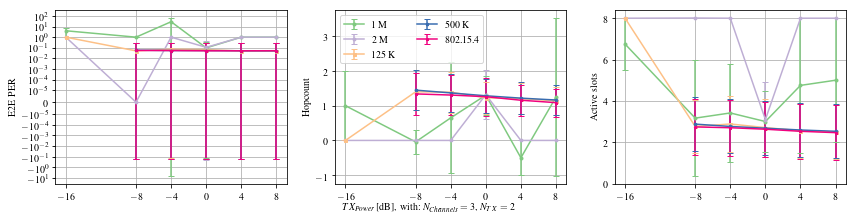

plotting: /Users/beshr/work/blueflood/examples/nrf-glossy/cau_testbed/evaluate_txpower_plot_cautestbed_ntx_4_exp_838_1207.pdf


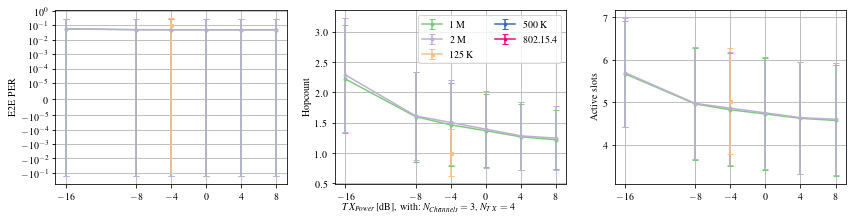

plotting: /Users/beshr/work/blueflood/examples/nrf-glossy/cau_testbed/evaluate_txpower_plot_cautestbed_ntx_8_exp_838_1207.pdf


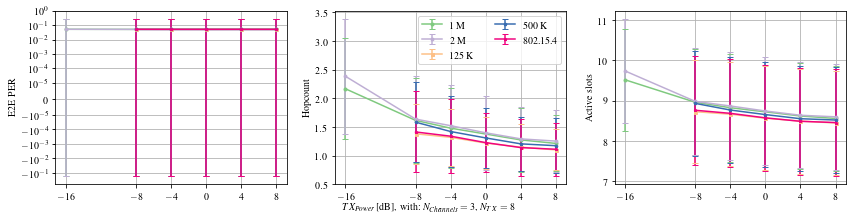

plotting: /Users/beshr/work/blueflood/examples/nrf-glossy/graz_testbed/evaluate_txpower_plot_graztestbed_ntx_2_exp_23245_27425.pdf


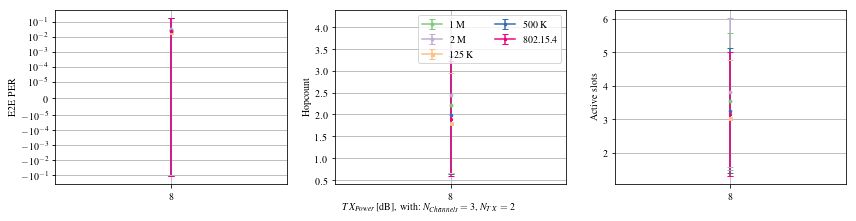

plotting: /Users/beshr/work/blueflood/examples/nrf-glossy/graz_testbed/evaluate_txpower_plot_graztestbed_ntx_4_exp_23245_27425.pdf


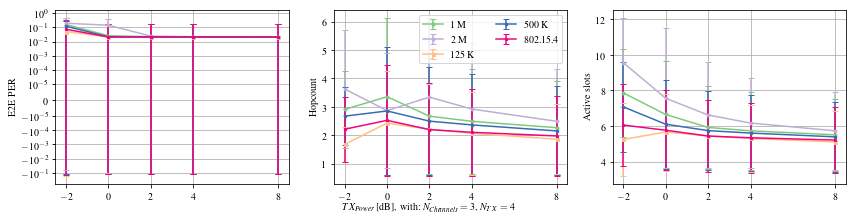

plotting: /Users/beshr/work/blueflood/examples/nrf-glossy/graz_testbed/evaluate_txpower_plot_graztestbed_ntx_8_exp_23245_27425.pdf


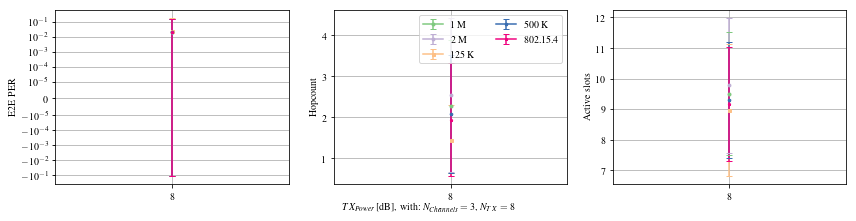

In [23]:
def plot_summary_testbed_ntx(testbed, parameters, startexp, endexp):
  [txoffset0, capture0, packet_size0, nch0, och0, ntx0] = parameters
  testbed = str(testbed).lower()
  wdirg="/Users/beshr/work/blueflood/examples/nrf-glossy/%s_testbed" %(testbed)
  plotfilename="evaluate_txpower_plot_%stestbed_ntx_%d_exp_%d_%d.pdf" % (testbed, ntx0, startexp, endexp)
  file_name = os.path.join(wdirg, plotfilename)
  print "plotting: " + file_name
  plot_summary_plots(globals()["txpowerdata_%s_ntx%d" % (testbed, ntx0)], blemodes, file_name, parameters)

[txoffset0, capture0, packet_size0, nch0, och0, ntx0] = [0, 0, 38, 3, 0, 8]
for ntx0 in [2, 4, 8]:
  plot_summary_testbed_ntx("cau", [txoffset0, capture0, packet_size0, nch0, och0, ntx0], startexpcau, maxjobid_cau)
for ntx0 in [2, 4, 8]:
  plot_summary_testbed_ntx("graz", [txoffset0, capture0, packet_size0, nch0, och0, ntx0], startexpgraz, maxjobid_graz)

# wdirg="/Users/beshr/work/blueflood/examples/nrf-glossy/home_testbed"
# plotfilename="evaluate_txpower_plot_hometestbed_ntx_%d_exp_%d_%d.pdf" % (ntx0, startexphome, maxjobid_home)
# file_name = os.path.join(wdirg, plotfilename)
# print "plotting: " + file_name
# plot_summary_plots(txpowerdata_home, blemodes, file_name)


In [160]:
def plot_summary_boxplots(txpowerdata, blemodes, file_name):
  capsize=3
  markersize=3
  linewidth=1.5
  linestyle=linestyles[0]
  norm = matplotlib.colors.Normalize(vmin=0, vmax=len(blemodes)+1)

  #fig = plt.figure(figsize=(4, 6))  #width, height
  fig, axx = plt.subplots(ncols=3, sharey=False, sharex=True, figsize=(12,3))
  #axmain = fig.add_subplot(111,frameon=False)
  # Turn off axis lines and ticks of the big subplot
  #axmain.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
  #axx[1].set_ylim(80, 100.5)

  for counter, ble_mode in enumerate(blemodes):
    color=plt.get_cmap('Accent')(norm(counter))
    marker=markers[counter]
  #   if res != 0:
  #     txp_per_err = list(np.asarray(txpowerdata[ble_mode]["perstd"]) + res)
  #     txp_per =  list(np.asarray(txpowerdata[ble_mode]["per"]) + res)
  #   #   yerr = np.log10(txp_per_err)
  #   #   y=np.log10(txp_per)
  #     yerr = txp_per_err
  #     y=txp_per
  #   else:
      #shallow copy
    yerr=copy.copy(txpowerdata[ble_mode]["perstd"])
    y=copy.copy(txpowerdata[ble_mode]["per"])
    yerr1=copy.copy(txpowerdata[ble_mode]["hopcountstd"])
    y1=copy.copy(txpowerdata[ble_mode]["hopcount"])
    yerr2=copy.copy(txpowerdata[ble_mode]["onslotsstd"])
    y2=copy.copy(txpowerdata[ble_mode]["onslots"])
    axx[0].errorbar(txpowerdata[ble_mode]["x"], y, yerr=yerr, linestyle=linestyle, color = color, marker=marker, markersize=markersize, capsize=capsize, elinewidth=linewidth, linewidth=linewidth)
    #axx[0].boxplot(y, positions=txpowerdata[ble_mode]["x"], notch=True)
    axx[1].errorbar(txpowerdata[ble_mode]["x"], y1, yerr=yerr1, label=ble_mode_str_dict[ble_mode], linestyle=linestyle, color = color, marker=marker, markersize=markersize, capsize=capsize, elinewidth=linewidth, linewidth=linewidth)
    #axx[1].boxplot(y1, positions=txpowerdata[ble_mode]["x"], notch=True)
    axx[2].errorbar(txpowerdata[ble_mode]["x"], y2, yerr=yerr2, linestyle=linestyle, color = color, marker=marker, markersize=markersize, capsize=capsize, elinewidth=linewidth, linewidth=linewidth)
    #axx[2].boxplot(y2, positions=txpowerdata[ble_mode]["x"], notch=True)

    axx[0].set_yscale('symlog', linthreshy=0.00001)
    axx[1].legend(loc="best",  ncol=2)
    
  ylabels=["E2E PER", "Hopcount", "Active slots"]
  for i, ax in enumerate(axx):
    ax.grid()
    # axx.set_yscale('log')
    #ax.set_xlim(min(txpowerdata[ble_mode]["x"])-0.2, max(txpowerdata[ble_mode]["x"])+0.2)
  #   ax.set_xlabel('TX power [dB]')
    ax.set_ylabel(ylabels[i])

  x_lbl="$TX_{Power}$ [dB], with: $N_{Channels}=%d$, $N_{TX}=%d$" %(nch0, ntx0)
  fig.text(0.5, 0.00, x_lbl, ha='center')
  fig.tight_layout()
  # plt.subplots_adjust(left=0, top=2)
  plt.savefig(file_name, bbox_inches='tight')
  plt.show()

plotting: /Users/beshr/work/blueflood/examples/nrf-glossy/graz_testbed/evaluate_txpower_boxplot_graztestbed-23245.pdf


ValueError: List of boxplot statistics and `positions` values must have same the length

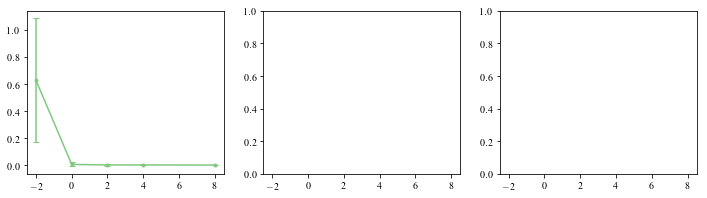

In [120]:
startexp=23245
wdirg="/Users/beshr/work/blueflood/examples/nrf-glossy/graz_testbed"
plotfilename="evaluate_txpower_boxplot_graztestbed-%d.pdf" % startexp
file_name = os.path.join(wdirg, plotfilename)
print "plotting: " + file_name
plot_summary_boxplots(txpowerdata_graz, blemodes, file_name)

startexp=1
wdirg="/Users/beshr/work/blueflood/examples/nrf-glossy/cau_testbed"
plotfilename="evaluate_txpower_boxplot_cautestbed-%d.pdf" % startexp
file_name = os.path.join(wdirg, plotfilename)
print "plotting: " + file_name
plot_summary_boxplots(txpowerdata_cau, blemodes, file_name)

wdirg="/Users/beshr/work/blueflood/examples/nrf-glossy/home_testbed"
plotfilename="evaluate_txpower_boxplot_hometestbed-%d.pdf" % startexp
file_name = os.path.join(wdirg, plotfilename)
print "plotting: " + file_name
plot_summary_boxplots(txpowerdata_home, blemodes, file_name)

In [3]:
### Parse experiment and save results
wdirg="/Users/beshr/work/blueflood/examples/nrf-glossy/graz_testbed"
exp_path = os.path.join(wdirg, "logs_23263")
nodes = load_testbed_node_log_files(exp_path);
saveObject(nodes, os.path.join(exp_path, "nodes.pickle"))       

In [ ]:
### Load parsed results
expid=23252
wdirg="/Users/beshr/work/blueflood/examples/nrf-glossy/graz_testbed"
exp_path = os.path.join(wdirg, "logs_%d" % (expid))
nodes = loadObject(os.path.join(exp_path, "nodes.pickle"))    

In [22]:
#y1 is plotted on log scale axis
def plot_exp(x, xticks, x_lbl, lbl, y1, yerr1, y2, yerr2, y3, yerr3, ylabels, expn, wdirg, color, fig=None, axx=None):
  capsize=3
  markersize=3
  linewidth=1.5
  linestyle=linestyles[0]
  #color='b'

  #fig = plt.figure(figsize=(4, 6))  #width, height
  if fig is None or axx is None:
    fig, axx = plt.subplots(ncols=3, sharey=False, sharex=True, figsize=(12,3))
#   plotfilename="plot_graztestbed_exp%d.pdf" % expn
#   file_name = os.path.join(wdirg, plotfilename)
  #print "plotting: " + x_lbl + ", " + lbl
  axx[0].errorbar(x, y1, yerr=yerr1, linestyle=linestyle, color = color, marker=marker, markersize=markersize, capsize=capsize, elinewidth=linewidth, linewidth=linewidth)
  axx[1].errorbar(x, y2, yerr=yerr2, label=lbl, linestyle=linestyle, color = color, marker=marker, markersize=markersize, capsize=capsize, elinewidth=linewidth, linewidth=linewidth)
  axx[2].errorbar(x, y3, yerr=yerr3, linestyle=linestyle, color = color, marker=marker, markersize=markersize, capsize=capsize, elinewidth=linewidth, linewidth=linewidth)
  #log scale, but make a linear region around zero to avoid problems with zero, as log(0) is nan
  axx[0].set_yscale('symlog', linthreshy=0.00001)
  axx[1].legend(loc="best",  ncol=1)

  for i, ax in enumerate(axx):
    ax.grid()
    #ax.set_xlim(min(txpowerdata[ble_mode]["x"])-0.2, max(txpowerdata[ble_mode]["x"])+0.2)
    ax.set_ylabel(ylabels[i])
    ax.set_xticks(x, minor=True)
    ax.set_xticklabels(xticks, minor=True)
    #ax.set_xticklabels(xticks[0:10:len(xticks)], minor=False)

    ax.minorticks_off()

  if x_lbl is not None:
    fig.text(0.5, 0.00, x_lbl, ha='center')
  fig.tight_layout()
  #plt.savefig(file_name, bbox_inches='tight')
  #plt.show()
  return fig, axx

In [32]:
#plot for one tx power
import itertools

def plot_micro_view_for_txpowers(expdict, expdesc, startexp, blemodes, txpowerset, params, plotnametemplate, wdirg):
  [txoffset0, capture0, packet_size0, nch0, och0, ntx0]=params
  norm = matplotlib.colors.Normalize(vmin=0, vmax=len(blemodes)+1)
  ncols=4
  for txpower0 in txpowerset:
    fig, axx = plt.subplots(ncols=ncols, sharey=False, sharex=False, figsize=(4*ncols,3))
    x_lbl_written = False
    for expid in expdesc.keys():
      if expid >= startexp:
        [ts, ble_mode, txpower, txoffset, capture, packet_size, nch, och, ntx, initiator, testbed] = expdesc[expid]
        if [txpower, txoffset, capture, packet_size, nch, och, ntx] == [txpower0, txoffset0, capture0, packet_size0, nch0, och0, ntx0]:
          nodes=expdict[expid].copy()
          nodeids=list(nodes.keys())
          nodeids.sort()
          x = range(0, len(nodeids), 1)

          y1 = [nodes[i]["PER"] for i in nodeids if nodes[i]["PER"] > -1]
          #yerr1 = np.std(y1)
          yerr1 = None   

#           syncslots = [list(np.asarray(nodes[i]["sync"].values()) + 1) if not nodes[i]["is_initiator"] else list(nodes[i]["sync"].values()) for i in nodeids]
#           syncslots = [nodes[i]["all"].values() for i in nodeids]
#           syncslots = [[ d[1] for d in row if not d[0] ] for row in syncslots ]
##         print syncslots
#           syncslots_flat = list(itertools.chain(*syncslots))
          y2 = [nodes[i]["hopcount"][2] if nodes[i]["hopcount"][2] > -1 else 0 for i in nodeids]
          yerr2 = [nodes[i]["hopcount"][3] if nodes[i]["hopcount"][2] > -1 else 0 for i in nodeids]
          #print syncslots
#           y2 = np.mean(syncslots ,axis=1)
#           y2 = [np.mean(s) if len(s)>0 else 0 for s in syncslots]
#           yerr2 = [np.std(s) if len(s)>0 else 0 for s in syncslots]

#           y3 = [np.mean(nodes[i]["tot"].values()) for i in nodeids]
#           yerr3 = [np.std(nodes[i]["tot"].values()) for i in nodeids]
          y3 = [nodes[i]["totslots"][2] if nodes[i]["totslots"][2] > -1 else 0 for i in nodeids]
          yerr3 = [nodes[i]["totslots"][3] if nodes[i]["totslots"][2] > -1 else 0 for i in nodeids]
    
          color=plt.get_cmap('Accent')(norm(blemodes.index(ble_mode)))
          lbl = ble_mode_str_dict[ble_mode]
          #x_lbl0="Experiment %d, Node IDs" % expid
          x_lbl0="Node index. Parameters: $TX_{Power}$=%d dB, $N_{Channels}=%d$, $N_{TX}=%d$" %(txpower0, nch0, ntx0)
          if not x_lbl_written:
            x_lbl = x_lbl0
            x_lbl_written = True
          else:
            x_lbl=None
          ylabels=["E2E PER", "Hopcount", "Active slots", "Sync slot Histogram", "Sync slot CDF"]
          print "plotting: " + x_lbl0 + ", " + lbl
          plot_exp(x, nodeids, x_lbl, lbl, y1, yerr1, y2, yerr2, y3, yerr3, ylabels, expid, wdirg, color, fig=fig, axx=axx)

          n_bins=int(np.max(syncslots_flat))
          #print syncslots
          linewidth=1.5
          n, bins, patches = axx[3].hist(syncslots_flat, n_bins, density=True, histtype='step',cumulative=True, color=color, linewidth=linewidth)
          axx[3].set_xticks(bins, minor=True)
          axx[3].set_xticklabels(bins, minor=True)
          axx[3].minorticks_off()
          axx[3].grid()
          axx[3].grid()
  #         bin_edges, cdf, hist = do_cdf(chain)
  #         axx[4].errorbar(bin_edges, cdf, color=color, linestyle=linestyle, marker=marker, markersize=markersize, capsize=capsize, elinewidth=linewidth, linewidth=linewidth)
  #         axx[4].set_xticks(bin_edges, minor=True)
  #         axx[4].set_xticklabels(bin_edges, minor=True)

    plotfilename= plotnametemplate % txpower0
    file_name = os.path.join(wdirg, plotfilename)
    plt.savefig(file_name, bbox_inches='tight')
    plt.show()

In [14]:
#plot for one rf mode
import itertools

def plot_micro_view_for_rfmodes(expdict, expdesc, startexp, blemodes, txpowerset, params, plotnametemplate, wdirg):
  [txoffset0, capture0, packet_size0, nch0, och0, ntx0]=params
  norm = matplotlib.colors.Normalize(vmin=min(txpowers), vmax=max(txpowers)+1)
  ncols=4
  ble_mode_name=0
  for ble_mode0 in blemodes:
    fig, axx = plt.subplots(ncols=ncols, sharey=False, sharex=False, figsize=(4*ncols,3))
    x_lbl_written=False
    for expid in expdesc.keys():
      if expid >= startexp:
        [ts, ble_mode, txpower, txoffset, capture, packet_size, nch, och, ntx, initiator, testbed] = expdesc[expid]
        if (txpower in txpowers) and ([ble_mode, txoffset, capture, packet_size, nch, och, ntx] == [ble_mode0, txoffset0, capture0, packet_size0, nch0, och0, ntx0]):
          ble_mode_name=ble_mode
          nodes=expdict[expid].copy()
          nodeids=list(nodes.keys())
          nodeids.sort()
          x = range(0, len(nodeids), 1)

          y1 = [nodes[i]["PER"] for i in nodeids if nodes[i]["PER"] > -1]
          #yerr1 = np.std(y1)
          yerr1 = None

          syncslots = [list(nodes[i]["all"].values()) for i in nodeids]
          syncslots = [[ d[1] for d in row if not d[0] ] for row in syncslots  ]
          
          syncslots_flat = list(itertools.chain(*syncslots))
          y2 = [np.mean(s) if len(s)>0 else 0 for s in syncslots]
          yerr2 = [np.std(s) if len(s)>0 else 0 for s in syncslots]
#           print len(y2), len(x)
#           print yerr2
#           syncslots = [list(np.asarray(nodes[i]["sync"].values()) + 1) if not nodes[i]["is_initiator"] else list(nodes[i]["sync"].values()) for i in nodeids]
#           syncslots_flat = list(itertools.chain(*syncslots))
#           y2 = [np.mean(s) for s in syncslots]
#           yerr2 = [np.std(s) for s in syncslots]

          y3 = [np.mean(nodes[i]["tot"].values()) for i in nodeids]
          yerr3 = [np.std(nodes[i]["tot"].values()) for i in nodeids]

          color=plt.get_cmap('Accent')(norm(txpower))
          lbl="$TX_{Power}$ %d dB" %(txpower)
          #x_lbl0="Experiment %d, Node IDs" % expid
          x_lbl0="Node index. Parameters: Mode: %s, $N_{Channels}=%d$, $N_{TX}=%d$" %(ble_mode_str_dict[ble_mode], nch, ntx)
          if not x_lbl_written:
            x_lbl = x_lbl0
            x_lbl_written = True
          else:
            x_lbl=None
          ylabels=["E2E PER", "Hopcount", "Active slots", "Sync slot Histogram", "Sync slot CDF"]
          print "plotting: " + x_lbl0 + ", " + lbl
          plot_exp(x, nodeids, x_lbl, lbl, y1, yerr1, y2, yerr2, y3, yerr3, ylabels, expid, wdirg, color, fig=fig, axx=axx)

          n_bins=int(np.max(syncslots_flat))
          #print syncslots
          linewidth=1.5
          n, bins, patches = axx[3].hist(syncslots_flat, n_bins, density=True, histtype='step',cumulative=True, color=color, linewidth=linewidth)
          axx[3].set_xticks(bins, minor=True)
          axx[3].set_xticklabels(bins, minor=True)
          axx[3].minorticks_off()
          axx[3].grid()
          axx[3].grid()
  #         bin_edges, cdf, hist = do_cdf(chain)
  #         axx[4].errorbar(bin_edges, cdf, color=color, linestyle=linestyle, marker=marker, markersize=markersize, capsize=capsize, elinewidth=linewidth, linewidth=linewidth)
  #         axx[4].set_xticks(bin_edges, minor=True)
  #         axx[4].set_xticklabels(bin_edges, minor=True)

    plotfilename= plotnametemplate % ble_mode_str_dict[ble_mode_name]
    file_name = os.path.join(wdirg, plotfilename)
    plt.savefig(file_name, bbox_inches='tight')
    plt.show()

In [ ]:
startexp=23245
blemodes = ble_mode_str_dict.keys()
blemodes.sort()
[txoffset0, capture0, packet_size0, nch0, och0, ntx0] = [0, 0, 38, 3, 0, 4]
params=[txoffset0, capture0, packet_size0, nch0, och0, ntx0]
txpowerset=[0, 2, 4]
plotnametemplate = "plot_graztestbed_exp_txpower_%d.pdf"
plot_micro_view_for_txpowers(expdict_graz, expdesc_graz, startexp, blemodes, txpowerset, params, plotnametemplate, wdirg)


In [ ]:
plotnametemplate = "plot_graztestbed_exp_rfmode_%s.pdf"
plot_micro_view_for_rfmodes(expdict_graz, expdesc_graz, startexp, blemodes, txpowerset, params, plotnametemplate, wdirg)

In [ ]:
blemodes = ble_mode_str_dict.keys()
blemodes.sort()
[txoffset0, capture0, packet_size0, nch0, och0, ntx0] = [0, 0, 38, 3, 0, 4]
txpowerset=[0, 2, 4]
params=[txoffset0, capture0, packet_size0, nch0, och0, ntx0]


In [130]:
### Do some stats on parsed results
hopcounts = [d["hopcount"] for d in list(nodes.values())]
per = [d["PER"] for d in list(nodes.values())]
print ' ', np.average(hopcounts, axis=0), np.std(hopcounts, axis=0), np.percentile(hopcounts, 70, axis=0)
print ' ',  100*np.average(per, axis=0), 100*np.std(per, axis=0), 100*np.min(per, axis=0), \
100*np.max(per, axis=0)
# Absolute mean deviation 
avg_per=np.mean(per)
stddev_per=np.std(per)
print ' Avg PER, std dev, Absolute mean deviation', 100*avg_per, 100*stddev_per, 100*np.mean(np.absolute(per - avg_per)) 

  [1.91666667 4.625      2.38166555 0.34668013] [1.32024829 3.02506887 1.78377485 0.34012608] [2.9        7.         3.61645081 0.52920302]
  0.0 0.0 0.0 0.0
 Avg PER, std dev, Absolute mean deviation 0.0 0.0 0.0


[4, 8, 4.667348329925017, 0.6135999307616697] 8


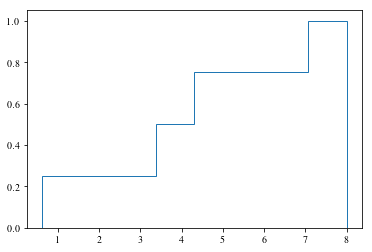

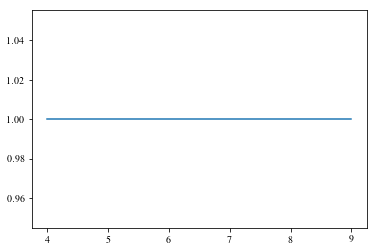

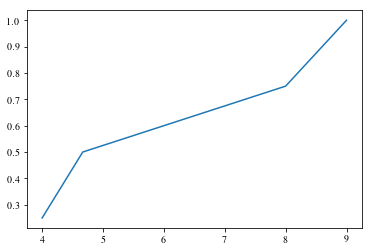

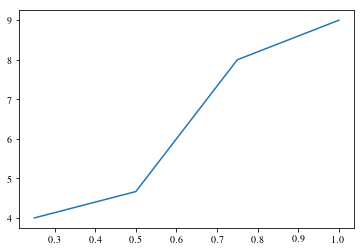

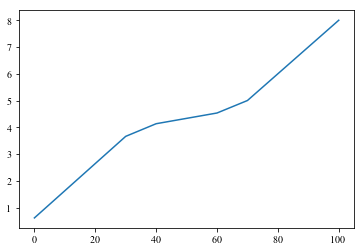

In [146]:
def do_cdf(series):
  ### from https://blog.finxter.com/numpy-cumsum/
  # s=Size of our data
  series_size=len(series)
  # Sort the data and set bins edges
  sorted_series = np.sort(series)
  bins = np.append(sorted_series, sorted_series[-1]+1)
  # Use the histogram function to bin the data
  hist1, bin_edges = np.histogram(series, bins = bins)
  # Account for the possible float data
  hist = hist1.astype(float)/series_size
  # Find the cdf
  cdf = np.cumsum(hist)
  return bin_edges[1:], cdf, hist1

def do_percentile(series):
  p=list()
  r=range(0,101,10)
  for i in r:
    p.append(np.percentile(series, i, axis=0))
  return r, p

# plot the cumulative histogram
x=hopcounts[3]
n_bins=int(np.max(x))
print x, n_bins
n, bins, patches = plt.hist(x, n_bins, density=True, histtype='step',cumulative=True, label='Empirical')
plt.show()

bin_edges, cdf, hist = do_cdf(hopcounts[3])
r, p = do_percentile(hopcounts[3])
# Plot the cdf
plt.plot(bin_edges, hist)
plt.show()
# Plot the cdf
plt.plot(bin_edges, cdf)
plt.show()
plt.plot(cdf, bin_edges)
plt.show()
plt.plot(r,p)
plt.show()

In [ ]:
##### EWSN Parsing functions and classes
#1534763630098560        ID:10   {tx-3} :8-----------------------
line_regex = re.compile("(\d+)\s+ID\:(\d+)\s+\{(\w+)-(\d+)\}\s(.*)")
def parse_experiment_line(line):
  #93_2018_08_20_13_12_56_ble_mode_3_txpower_-20_txoffset_0_capture_0
  res = line_regex.match(line)
  parsed = None
  if res:
    ts = int(res.group(1))
    nid = int(res.group(2))
    subject = str(res.group(3))
    rd = int(res.group(4))
    lline = str(res.group(5))
    parsed = ts, nid, subject, rd, lline
  return parsed

#dirname_regex = re.compile("(\d+)_(\d+)_(\d+)_(\d+)_(\d+)_(\d+)_(\d+)_ble_mode_(\d)_txpower_(-?\d+)_txoffset_(-?\d+)_capture_(\d)")
#617_2019_11_20_12_38_45_dirty-channel__ble_mode_6_txpower_-4_txoffset_0_capture_0_packet_size_38_nch_40_och_0_ntx_4_i_3_testbed_CAU_TESTBED

dirname_regex = re.compile("(\d+)_(\d+)_(\d+)_(\d+)_(\d+)_(\d+)_(\d+)(?:_dirty-channel)?_?_ble_mode_(\d+)_txpower_(-?\d+)_txoffset_(-?\d+)_capture_(\d)(_packet_size_(\d+))?(_nch_(\d+))?(_och_(\d+))?(_ntx_(\d+))?(_i_\d+_testbed_CAU_TESTBED)?")
#     nch = 40 #number of channels
#     och = 0 #override channel 37 to non-standard 2498MHz e.g., WiFi and Bluetooth clean.
#     ntx = 4
# packet_size = 38 #PDU size
def parse_experiment_dirname(dirname, nch=1, och=1, ntx=4, packet_size = 38):
  #93_2018_08_20_13_12_56_ble_mode_3_txpower_-20_txoffset_0_capture_0
#439_2018_09_12_14_30_34_ble_mode_6_txpower_-12_txoffset_0_capture_0_packet_size_38_nch_40_och_0
  res = dirname_regex.match(dirname)
  #print dirname
  parsed = None
  if res:
    exp_number = int(res.group(1))
    ts = [int(res.group(2)), int(res.group(3)), int(res.group(4)), int(res.group(5)), int(res.group(6)),int(res.group(7))]
    ble_mode = int(res.group(8))
    txpower = int(res.group(9))
    txoffset = int(res.group(10))
    capture = int(res.group(11))
    

    if res.group(12):
        if str(res.group(12)).startswith("_packet_size_"):
            packet_size = int(res.group(13))
    if res.group(14):
        if str(res.group(14)).startswith("_nch_"):
            nch = int(res.group(15))
    if res.group(16):
        if str(res.group(16)).startswith("_och_"):
            och = int(res.group(17))
    if res.group(18):
        if str(res.group(18)).startswith("_ntx_"):
            ntx = int(res.group(19))
            
    parsed = [exp_number, ts, ble_mode, txpower, txoffset, capture, packet_size, nch, och, ntx]
  return parsed
#515_2019_11_13_19_08_41_dirty-channel_ble_mode_3_txpower_-20_txoffset_0_capture_0

filename_regex = re.compile("(\d+)_(\d+)_(\d+)_(\d+)_(\d+)_(\d+)_(\d+)(?:\_dirty-channel)_ble_mode_(\d+)_txpower_(-?\d+)_(-?\d+)_txoffset_(-?\d+)_capture_(\d).log")
def parse_experiment_filename(log):
  res = filename_regex.match(log)
  parsed = None
  if res:
    #timestamp = float(res.group(1))
    ts = [int(res.group(1)), int(res.group(2)), int(res.group(3)), int(res.group(4)), int(res.group(5)), int(res.group(6))]
    ble_mode = int(res.group(8))
    txpower = [int(res.group(9)), int(res.group(10))]
    txoffset = int(res.group(11))
    capture = int(res.group(12))
    parsed = [ts, ble_mode, txpower, txoffset, capture]
  else:
    print "!fialed to parse_experiment_filename"
  return parsed
  
##############################################################
class Node:
    testbed_node_ids=[1,2,3,4,5,6,7,8,9,10,12,13,14,15,16,17,18,19,20,21]
    nodes_set = set()
    nodes_dict = dict()
    def __init__(self, node_id, rd = None, ts = None, subject = None, rdline = None):
        self.node_index = self.testbed_node_ids.index(node_id)
        self.node_id = node_id
        Node.nodes_set.add(node_id)
        self.rounds_set = set()
        self.rounds = dict()
        if rd is not None:
            self.add_round(rd, ts, subject, rdline)
            
    def add_round(self, rd, ts = None, subject = None, rdline = None):
        if rd not in self.rounds_set:
            self.rounds_set.add(rd)
            r = Round(rd, ts)
            self.rounds[rd] = r
        else:
            r = self.rounds[rd]
        if subject is not None and rdline is not None:
            r.process_round_line(subject, rdline)
            
    @staticmethod
    def process_line(line, nodes_dict_):
        parsed = parse_experiment_line(line)
        if parsed:
            ts, nid, subject, rd, lline = parsed
            if nid not in Node.nodes_set:
                n = Node(nid, rd, ts, subject, lline)
                nodes_dict_[nid] = n
            else:
                n = nodes_dict_[nid]
                n.add_round(rd, ts, subject, lline)
        return parsed is not None
    
    #!!  check why the initiator PRR is less than 1!
    @staticmethod
    def do_performance_metrics(nodes_dict_):
        prr=dict()
        prr_round=dict()
        latency = dict()
        for n in nodes_dict_.values():
            tot_not_ok_rd = [r.tot_not_ok for r in n.rounds.values() if r.valid]
            tot_rx_rd = [r.tot_rx for r in n.rounds.values() if r.valid]
            if sum(tot_rx_rd) != 0:
                prr_round[n.node_id] = 1 - (1.0*sum(tot_not_ok_rd)/sum(tot_rx_rd))
            else: 
                prr_round[n.node_id] = 0
            
            sync_slots = [r.sync_slot for r in n.rounds.values() if r.valid]
            sync_slots_ok = [s for s in sync_slots if s > 0]
            tot_not_ok = len(sync_slots) - len(sync_slots_ok)
            if len(sync_slots) != 0:
                prr[n.node_id] = (1.0*len(sync_slots_ok) / len(sync_slots))
                latency[n.node_id] = 1.0*sum(sync_slots_ok) / len(sync_slots)
            else: 
                prr[n.node_id] = 0
                latency[n.node_id] = -1

        return prr_round, prr, latency

##############################################################################
class Round:
    ROUND_LEN=16
    def __init__(self, rd, ts=None):
        self.round = rd
        self.ts = ts
        self.txdelta = []
        self.rssi = []
        self.txdelta_ok = dict() #when rx ok or when rx crc error
        self.rssi_ok = dict() #when rx ok or when rx crc error
        self.rx = []
        self.tx_status_tx = []
        self.tx_status_bad_rx = []
        self.tx_status = ""
        self.tot_tx = 0
        self.tot_not_ok = 0
        self.tot_ok = 0
        self.tot_rx = 0
        self.valid = False
        #self.sync_slot = -1 #reported
        self.sync_slot = -1 #first rx ok
        #did we remove rssi and tx delta entries that correspond to invalid rx?
        self.cross_checked_with_tx_status = False 
        self.initiator = -1
        
    def process_round_line(self, subject, lline):
        if subject.startswith("rssi"):
            sstr = lline.split(',')
            try:
                self.rssi = [int(r) for r in sstr[1:len(sstr)-1]]
            except:
                #print lline
                pass
        #print rssi
        elif subject.startswith("td"):
            sstr = lline.split(',')
            try:
                self.txdelta = [int(r) for r in sstr[1:len(sstr)-1]]
            except:
                #print lline
                pass
            #print ts_delta
        elif subject.startswith("rx"):
            sstr = lline.split(',')
            try:
                self.rx = [int(r) for r in sstr[0:len(sstr)]]
            except:
                #print lline
                pass
            #print "len(self.rx) %d" %(len(self.rx))
            #self.sync_slot = self.rx[len(self.rx)-1]
            #print ts_delta
        elif subject.startswith("tx"):
            lline=str(lline)
            if len(lline) > 1: #and len(lline) <= Round.ROUND_LEN+1:
#                 if(len(lline)<Round.ROUND_LEN):
#                     lline = lline.rjust(Round.ROUND_LEN+ 1, "A")
#                     lline=lline.replace(':','A') #replace 
                ch=lline[1]
                #replace left dots with the letter, and remove the right dots!
                lline=re.sub(r'\.*$',r'',lline) #remove trailing dots
                lline=lline.replace('.',ch) #replace left dots with the first letter
                self.tx_status = lline[1:]  #remove ":"                  
                #print self.tx_status
                synced = self.tx_status.find("-") 
                self.sync_slot = 1 + synced if synced != -1 else -1  #first rx ok
                self.tx_status_bad_rx = [tx_status_map_bad_rx(t) for t in self.tx_status]
                self.tx_status_tx = [tx_status_map_tx(t) for t in self.tx_status]
                is_initiator = self.tx_status[0] in ['B', '1', '2']
                self.initiator = is_initiator
                tot_rx_correction = 0
                tot_not_ok_correction = 0
                if is_initiator:
                    self.sync_slot = 1
#                     tot_rx_correction = 0
#                     tot_not_ok_correction = 0
#                 else:
#                     if synced != -1:
#                         tot_rx_correction = 0
#                         tot_not_ok_correction = 0
#                     else:
#                         tot_rx_correction = 0
#                         tot_not_ok_correction = 0

                tot=len(self.tx_status)
                self.tot_not_ok = sum(self.tx_status_bad_rx)+tot_not_ok_correction
                self.tot_tx = sum(self.tx_status_tx)
                self.tot_ok = tot - self.tot_not_ok - self.tot_tx
                self.tot_rx = tot - self.tot_tx + tot_rx_correction
                self.valid = True
            else:
                return
            
    def cross_check_with_tx_status(self):
        if len(self.tx_status) > 1 and len(self.txdelta) > 1 and len(self.rssi) > 1:
            self.cross_checked_with_tx_status = True 
            for i in range(0,len(self.tx_status)):
                if self.tx_status[i] == '-':
                    if i < len(self.rssi):
                        self.rssi_ok[i] = self.rssi[i]
                    if i < len(self.txdelta):
                        self.txdelta_ok[i] = self.txdelta[i]
##############################################################################
def load_testbed_log_file(in_filename, dirname):
    #experiment_parameters
    dn = os.path.basename(os.path.normpath(dirname))
    exp_number, ts, ble_mode, txpower, txoffset, capture, packet_size, nch, och, ntx = parse_experiment_dirname(dn)

    print dn, [exp_number, ts, ble_mode, txpower, txoffset, capture, packet_size, nch, och, ntx]
    ppm=[]

    for lline in open(os.path.join(dirname, in_filename), 'r').readlines():
        if lline:
            sline=lline.strip()
            Node.process_line(sline, Node.nodes_dict)
            
    for n in Node.nodes_dict.values():
        for r in n.rounds.values():
            r.cross_check_with_tx_status()
            #ppmtmp = [0]
            #ppmtmp.extend(r.txdelta_ok.values())
            ppmtmp = r.txdelta_ok.values()
            if len(ppmtmp)>0:
                ppm.append(np.max(ppmtmp))
            #print n.node_id, r.round, r.txdelta_ok
    
    
    #print "ppm %f %f" % (np.max(ppm), np.average(ppm))
    #print ppm
    
    prr_round, prr, latency = Node.do_performance_metrics(Node.nodes_dict) 
    #print prr_round, prr, latency
    rs = [np.average(prr_round.values()), np.average(prr.values()), np.average([l for l in latency.values() if l > 0])]
    result = [exp_number, ts, ble_mode, txpower, txoffset, capture]
    result.append([prr_round, prr, latency])
    result.append(rs)
    #print result
    return result
#######################################################
#ble_mode, txpower, txoffset, capture
results_dict_usage = {'ble_mode':0, 'txpower':1, 'txoffset':2, 'capture':3, 'packet_size':4, 'nch':5, 'och':6, 'ntx':7}
results_usage = {'prr_rounds':0, 'prr':1, 'latency':2}
########################################################
def extract_summary(results_dict, ble_modes_list, txpower_list, ntx_list, nch_list, ps_list, och=0, capture =0, txoffset=0):
    summary=dict()

    keys=results_dict.keys()
    keys.sort()

    for ble_mode in ble_modes_list:
        x=[]
        prr_avg=[]
        prr_stddev=[]
        performance=[]

        for ps in ps_list:
            for nch in nch_list:
                for ntx in ntx_list:
                    for txpower in txpower_list:
                        #[prr_round, prr, latency]
                        kk=tuple([ble_mode, txpower, txoffset, capture, ps, nch, och, ntx])
                        if not kk in keys:
                            print "#!Missing experiment: %s" % (str(kk))
                            performance.append([[0]*3,[0]*3])
                            #continue
                        else:
                            rs = results_dict[kk][6]
                            #[np.average(prr_round.values()), np.average(prr.values()), np.average([l for l in latency.values() if l > 0])]
                            rss = results_dict[kk][7]
                            latency=[l for l in rs[2].values() if l > 0 and l < 1000]
                            exp_number = results_dict[kk][0]
                            #print exp_number, latency
                            avg = [rss[0], rss[1], np.average(latency)]
                            stddev = [np.std(rs[0].values()), np.std(rs[1].values()), np.std(latency)]
                            performance.append([avg,stddev])
        summary[ble_mode]=np.array(performance)
    return summary

In [86]:
wdir="/Users/beshr/work/blueflood/examples/nrf-glossy/cau_testbed"
use_saved_results = 1
EXP_RANGE=range(515,550)
EXP_RANGE=range(596,618)
EXP_RANGE=range(650,674)
EXP_RANGE=range(683,703+1)

CAU_TESTBED=1
START_EXPERIMENT=EXP_RANGE[0] 
THIS_ROUND_LEN=16
results_dict = None
#results_dict = loadObject(os.path.join(wdir, "results_dict_%d.pickle" % 571))

if results_dict is None:
    results_dict = dict()

results =[]
dirs=os.listdir(wdir)
dirs.sort()
#result = load_testbed_log_file("logs/log.txt", os.path.join(wdir,"100_2018_08_20_17_02_39_ble_mode_3_txpower_-20_txoffset_0_capture_0"))
for infilename in dirs:
    #print infilename
    exp_path = os.path.join(wdir,infilename)
    if os.path.isdir(exp_path):
        #515_2019_11_13_19_08_41_dirty-channel_ble_mode_3_txpower_-20_txoffset_0_capture_0
        if CAU_TESTBED:
          #specify the values of the default parameters that are not written in the experiment name
          parsed = parse_experiment_dirname(infilename, nch=40, och=0, ntx=4, packet_size=38)
        else:
          parsed = parse_experiment_dirname(infilename, nch=1, och=1, ntx=4, packet_size=38)
          
        if parsed is not None:
            print infilename
            exp_number, ts, ble_mode, txpower, txoffset, capture, packet_size, nch, och, ntx = parsed
            if exp_number in EXP_RANGE:
                START_EXPERIMENT = max(START_EXPERIMENT, exp_number)
#                 print exp_number
                if use_saved_results:
                    results = loadObject(os.path.join(exp_path, "results.pickle"))
                    Node.nodes_dict = loadObject(os.path.join(exp_path, "nodes_dict.pickle"))
                else:
                    if os.path.exists(os.path.join(exp_path,"logs/log.txt")):
                        #!!!configure correct round length before processing
                        if exp_number < 134:
                            Round.ROUND_LEN=24
                        else:
                            Round.ROUND_LEN=THIS_ROUND_LEN
                        results = load_testbed_log_file("logs/log.txt", exp_path)
                        #print tuple(results[2:6])
                        #ble_mode, txpower, txoffset, capture
                        #exp_number, ts, ble_mode, txpower, txoffset, capture, packet_size, nch, och, ntx = parse_experiment_dirname(os.path.basename(os.path.normpath(exp_path)))
                        #print exp_number, ts, ble_mode, txpower, txoffset, capture, packet_size, nch, och, ntx
                        if ntx==0:
                            ntx=THIS_ROUND_LEN
                        results_dict[tuple([ble_mode, txpower, txoffset, capture, packet_size, nch, och, ntx])] = results
                        saveObject(results, os.path.join(exp_path, "results.pickle"))
                        saveObject(Node.nodes_dict, os.path.join(exp_path, "nodes_dict.pickle"))
if(use_saved_results):
  if os.path.exists(os.path.join(wdir, "results_dict_%d-%d.pickle" % (EXP_RANGE[0],EXP_RANGE[-1]))):
    results_dict = loadObject(os.path.join(wdir, "results_dict_%d-%d.pickle" % (EXP_RANGE[0],EXP_RANGE[-1])))
  elif os.path.exists( os.path.join(wdir, "results_dict_%d.pickle" % START_EXPERIMENT) ):
    results_dict = loadObject(os.path.join(wdir, "results_dict_%d.pickle" % START_EXPERIMENT))
  else:
    print "Saved results not found!"
    exit(0)

else:
    saveObject(results_dict, os.path.join(wdir, "results_dict_%d-%d.pickle" % (EXP_RANGE[0],EXP_RANGE[-1])))
print results_dict
                

108_2019_09_10_13_48_52_dirty-channel__ble_mode_3_txpower_0_txoffset_0_capture_0_packet_size_38_nch_3_och_0_ntx_4_i_0_testbed_TABLE_TESTBED
109_2019_09_10_13_48_52_dirty-channel__ble_mode_3_txpower_0_txoffset_0_capture_0_packet_size_38_nch_3_och_0_ntx_4_i_0_testbed_TABLE_TESTBED
111_2019_09_10_17_49_02_dirty-channel__ble_mode_3_txpower_0_txoffset_0_capture_0_packet_size_38_nch_3_och_0_ntx_4_i_0_testbed_CAU_TESTBED
232_2019_10_10_13_40_48_dirty-channel__ble_mode_3_txpower_0_txoffset_0_capture_0_packet_size_38_nch_40_och_0_ntx_4_i_3_testbed_CAU_TESTBED
234_2019_10_10_14_57_42_dirty-channel__ble_mode_3_txpower_0_txoffset_0_capture_0_packet_size_38_nch_40_och_0_ntx_4_i_3_testbed_CAU_TESTBED
235_2019_10_10_15_00_49_dirty-channel__ble_mode_15_txpower_0_txoffset_0_capture_0_packet_size_38_nch_40_och_0_ntx_4_i_3_testbed_CAU_TESTBED
241_2019_10_11_12_56_27_dirty-channel__ble_mode_15_txpower_0_txoffset_0_capture_0_packet_size_38_nch_40_och_0_ntx_4_i_3_testbed_CAU_TESTBED
249_2019_10_14_13_18_15_

684_2019_11_22_17_36_13_dirty-channel_ble_mode_3_txpower_-16_txoffset_0_capture_0_packet_size_38_nch_3_och_0_ntx_4_i_0_testbed_CAU_TESTBED
684_2019_11_22_17_36_13_dirty-channel_ble_mode_3_txpower_-16_txoffset_0_capture_0_packet_size_38_nch_3_och_0_ntx_4_i_0_testbed_CAU_TESTBED [684, [2019, 11, 22, 17, 36, 13], 3, -16, 0, 0, 38, 3, 0, 4]
685_2019_11_22_17_36_24_dirty-channel_ble_mode_3_txpower_-8_txoffset_0_capture_0_packet_size_38_nch_3_och_0_ntx_4_i_0_testbed_CAU_TESTBED
685_2019_11_22_17_36_24_dirty-channel_ble_mode_3_txpower_-8_txoffset_0_capture_0_packet_size_38_nch_3_och_0_ntx_4_i_0_testbed_CAU_TESTBED [685, [2019, 11, 22, 17, 36, 24], 3, -8, 0, 0, 38, 3, 0, 4]
686_2019_11_22_17_36_33_dirty-channel_ble_mode_3_txpower_-4_txoffset_0_capture_0_packet_size_38_nch_3_och_0_ntx_4_i_0_testbed_CAU_TESTBED
686_2019_11_22_17_36_33_dirty-channel_ble_mode_3_txpower_-4_txoffset_0_capture_0_packet_size_38_nch_3_och_0_ntx_4_i_0_testbed_CAU_TESTBED [686, [2019, 11, 22, 17, 36, 33], 3, -4, 0, 0, 38

In [82]:
print  '', EXP_RANGE, EXP_RANGE[0], EXP_RANGE[-1]
print results_dict

 [596, 597, 598, 599, 600, 601, 602, 603, 604, 605, 606, 607, 608, 609, 610, 611, 612, 613, 614, 615, 616, 617] 596 617
{(3, -4, 0, 0, 38, 40, 0, 4): [614, [2019, 11, 20, 12, 36, 20], 3, -4, 0, 0, [{2: 0.9340748779164406, 3: 0.9495033112582781, 4: 0.3774333333333333, 5: 0.4672821069780071, 6: 0.9873817034700315, 7: 0.9526709106006089, 9: 0.4278613147756928, 10: 0.4369289340101523, 12: 0.9272629310344828, 13: 0.3541623631481099, 16: 0.5048557975279576, 18: 0.42377260981912146, 19: 0.36438704213423667, 20: 0.39264857437306766}, {2: 1.0, 3: 0.9997094712376525, 4: 1.0, 5: 1.0, 6: 1.0, 7: 1.0, 9: 1.0, 10: 1.0, 12: 1.0, 13: 0.9962231260894828, 16: 0.9962253193960511, 18: 1.0, 19: 1.0, 20: 0.9968023255813954}, {2: 1.0705779843160035, 3: 1.0499709471237653, 4: 1.0, 5: 2.140034863451482, 6: 1.012779552715655, 7: 1.0496804183614177, 9: 2.33720592506535, 10: 2.2887017136218413, 12: 1.0784427658338176, 13: 2.7751307379430563, 16: 1.9355400696864111, 18: 2.3597560975609757, 19: 2.744334689134224, 2

In [50]:
wdir="/Users/beshr/work/chaos/examples/nrf-glossy/testbedjobscopy"
exp="604_2018_09_19_12_47_05_ble_mode_3_txpower_-16_txoffset_0_capture_0_packet_size_38_nch_40_och_0_ntx_4" 
exp="490_2018_09_14_01_11_23_ble_mode_5_txpower_-16_txoffset_0_capture_0_packet_size_38_nch_3_och_0_ntx_4"
exp_path = os.path.join(wdir,exp)
results_tmp = loadObject(os.path.join(exp_path, "results.pickle"))
print results_tmp

[490, [2018, 9, 14, 1, 11, 23], 5, -16, 0, 0, [{2: 0.5746976135992155, 3: 0.5134000419844658, 10: 0.5877455877455877, 12: 0.6024930747922438, 16: 0.5192140999711066, 17: 0.6200997861724875, 19: 0.5, 20: 0.6011699931176875}, {2: 0.9417161359956827, 3: 1.0, 10: 0.9407646742057081, 12: 0.9410492157923201, 16: 0.9409534127843987, 17: 0.9410492157923201, 19: 0.9406688241639698, 20: 0.9407646742057081}, {2: 0.9962223421478683, 3: 1.0, 10: 1.011308562197092, 12: 1.0313683071930773, 16: 1.0704225352112675, 17: 0.9870200108166577, 19: 1.3203883495145632, 20: 1.0339256865912763}], [0.5648525246728493, 0.9483707691175135, 1.0563319742089754]]


In [124]:
def plot_testbed_prr_txpower(wdir, xlist, ydict, ykeys, idx, lbls):
    norm = matplotlib.colors.Normalize(vmin=0, vmax=4)
    linewidth=1.5
    markersize=3 
    capsize=3
    #fig = plt.figure(figsize=(4, 6))  #width, height
    fig, axx = plt.subplots(ncols=3, sharey=False, sharex=True,figsize=(16,1))
    #axmain = fig.add_subplot(111,frameon=False)
    # Turn off axis lines and ticks of the big subplot
    #axmain.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
    axx[1].set_ylim(80, 100.5)
    #axx[0].set_ylim(60, 100.5)
    #axx[2].set_ylim(0, 6)

    lables = []
    titles = ()
    txoffset = 0
    capture = 0
    
    plotfilename="evaluate_txpower_plot_testbed-%d.pdf" % START_EXPERIMENT
    file_name = os.path.join(wdir, plotfilename)
    print "plotting: " + file_name
    for counter, ble_mode in enumerate(ykeys):
        color=plt.get_cmap('Accent')(norm(counter))
        l=lbls[ble_mode]
        lables.append(l)
        arr = ydict[ble_mode]
        if len(arr) <= 0:
            continue
        prr_rounds = 100*arr[:,0,0]
        prr_rounds_err = 100*ydict[ble_mode][:,1,0]
        prr = 100*ydict[ble_mode][:,0,1]
        prr_err = 100*ydict[ble_mode][:,1,1]
        latency = ydict[ble_mode][:,0,2]
        latency_err = ydict[ble_mode][:,1,2]
        
        data = []
        for ll in tuple([prr_rounds, prr_rounds_err, prr,  prr_err, latency, latency_err]):
            if len(ll) < len(xlist):
                ll = np.append(ll, [0] * (len(xlist) - len(ll)))
            data.append(ll)
            print ble_mode, xlist, ll
        axx[0].errorbar(xlist, data[0], yerr=data[1], label = l, color=color, linewidth=linewidth, marker=markers[counter], linestyle=linestyles[counter], markersize=markersize, capsize=capsize, elinewidth=linewidth)
        axx[1].errorbar(xlist, data[2], yerr=data[3], label = l, color=color, linewidth=linewidth, marker=markers[counter], linestyle=linestyles[counter], markersize=markersize, capsize=capsize, elinewidth=linewidth)
        axx[2].errorbar(xlist, data[4], yerr=data[5], label = l, color=color, linewidth=linewidth, marker=markers[counter], linestyle=linestyles[counter], markersize=markersize, capsize=capsize, elinewidth=linewidth)

    axx[1].legend(loc="best",  ncol=1)

    ylabels=["PRR per slot %", "E2E PDR %", "Latency [slots]"]
    for i, ax in enumerate(axx):
        ax.grid()
        ax.set_xlabel('TX power [dB]')
        ax.set_ylabel(ylabels[i])
    plt.xticks(xlist,xlist)
    plt.subplots_adjust(left=0, top=2)
    plt.savefig(file_name, bbox_inches='tight')
    #plt.show()
    #pause
    plt.close(fig)

def plot_testbed_x(wdir, xlist, ydict, ykeys, idx, lbls, x_lbl, name, dolatency=False, dolatencyMs=False, zoominY=False):
    norm = matplotlib.colors.Normalize(vmin=0, vmax=4)
    linewidth=1.5
    markersize=3 
    capsize=3
    #fig = plt.figure(figsize=(4, 6))  #width, height
    ncols=2
    latencyFigs = 0
    ylabels=["$PRR_{per slot}$ \%", "E2E PDR \%", ]
    latencyMsConversion=blueFloodSlotSizes
    if dolatency: 
        latencyFigs=latencyFigs+1 
        ylabels.append("Hop-count [slots]")
    if dolatencyMs: 
        latencyFigs=latencyFigs+1
        ylabels.append("Latency [ms]")

    ncols = ncols + latencyFigs
    fig, axx = plt.subplots(ncols=ncols, sharey=False, sharex=True,figsize=(3*ncols,2))
    #axmain = fig.add_subplot(111,frameon=False)
    # Turn off axis lines and ticks of the big subplot
    #axmain.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
    #axx[1].set_ylim(80, 100.5)
    #axx[0].set_ylim(60, 100.5)
    #axx[2].set_ylim(0, 6)

    lables = []
    titles = ()
    txoffset = 0
    capture = 0
    
    plotfilename="%s_testbed-%d.pdf" % (name, START_EXPERIMENT)
    file_name = os.path.join(wdir, plotfilename)
    print "plotting: " + file_name
    for counter, ble_mode in enumerate(ykeys):
        color=plt.get_cmap('Accent')(norm(counter))
        l=lbls[ble_mode]
        lables.append(l)
        if len(ydict[ble_mode]) <= 0:
            continue
        prr_rounds = 100*ydict[ble_mode][:,0,0]
        prr_rounds_err = 100*ydict[ble_mode][:,1,0]
        prr = 100*ydict[ble_mode][:,0,1]
        prr_err = 100*ydict[ble_mode][:,1,1]

        
        axx[0].errorbar(xlist, prr_rounds, yerr=prr_rounds_err, label = l, color=color, linewidth=linewidth, marker=markers[counter], linestyle=linestyles[counter], markersize=markersize, capsize=capsize, elinewidth=linewidth)
        axx[1].errorbar(xlist, prr, yerr=prr_err, label = l, color=color, linewidth=linewidth, marker=markers[counter], linestyle=linestyles[counter], markersize=markersize, capsize=capsize, elinewidth=linewidth)
        if dolatency or dolatencyMs:
            latency = ydict[ble_mode][:,0,2]
            latency_err = ydict[ble_mode][:,1,2]
            if dolatency:
                axx[ncols-latencyFigs].errorbar(xlist, latency, yerr=latency, label = l, color=color, linewidth=linewidth, marker=markers[counter], linestyle=linestyles[counter], markersize=markersize, capsize=capsize, elinewidth=linewidth)
            if dolatencyMs:
                latency = latency * latencyMsConversion[ble_mode]
                latency_err = latency_err * latencyMsConversion[ble_mode]
                axx[ncols-1].errorbar(xlist, latency, yerr=latency, label = l, color=color, linewidth=linewidth, marker=markers[counter], linestyle=linestyles[counter], markersize=markersize, capsize=capsize, elinewidth=linewidth)

    axx[1].legend(loc="best",  ncol=2)
    if zoominY:
      axx[1].set_ylim(99, 100.5)

    for i, ax in enumerate(axx):
        ax.grid()
        #ax.set_xlabel(x_lbl)
        ax.set_ylabel(ylabels[i])
    fig.text(0.5, 0.02, x_lbl, ha='center')

    plt.xticks(xlist,xlist)
    #plt.subplots_adjust(left=0, top=2)
    fig.tight_layout()
    plt.savefig(file_name, bbox_inches='tight')
    #plt.show()
    #pause
    plt.close(fig)


In [48]:
plot_testbed_prr_txpower(wdir, txpower_list, summary, [Ble_1Mbit, Ble_2Mbit, Ble_LR500Kbit, Ble_LR125Kbit], results_usage['prr'], ble_mode_str_dict)


NameError: name 'summary' is not defined

In [125]:
extract_keys=0
if extract_keys:
    exp_parameters = results_dict.keys()
    print exp_parameters
    txpower_list = list(set([x[1] for x in exp_parameters]))
    txpower_list.sort()
    print txpower_list
    ps_list = list(set([x[results_dict_usage['packet_size']] for x in exp_parameters]))
    ps_list.sort()
    print  ps_list
    nch_list = list(set([x[results_dict_usage['nch']] for x in exp_parameters]))
    nch_list.sort()
    print nch_list
    ntx_list = list(set([x[results_dict_usage['ntx']] for x in exp_parameters]))
    ntx_list.sort()
    print ntx_list
    #txpower_list =[-20, -16, -8, -4, 0, 4, 8]
    ps_list =[38]
    nch_list =[3] #40 in reality
    ntx_list =[4] #4 in reality
    #print txpower_list, keys
    ble_modes_list = [Ble_1Mbit, Ble_2Mbit, Ble_LR125Kbit, Ble_LR500Kbit, IEER802154_250Kbit]    

nCh=3
txP=-16
ps=38
nTx=4
och=0 #0 in reality
plot_ptx_nch_1_ps_38=1
if plot_ptx_nch_1_ps_38:
    xax=txpower_list
    print xax
    for nChi in [nCh]:
        plotfilename="txP_nCh_%d_nTx_%d" % (nChi,nTx)
        summary_ptx_nch_1 = extract_summary(results_dict, ble_modes_list, txpower_list=txpower_list, ntx_list=[nTx], nch_list=[nChi], ps_list=[ps], och=och)
        plot_testbed_x(wdir, xax, summary_ptx_nch_1, ble_modes_list, results_usage['prr'], ble_mode_str_dict,"$TX_{Power}$ [dB], with: $N_{Channels}=%d$, $N_{TX}=%d$" %(nChi, nTx), plotfilename, dolatency=True, dolatencyMs=True, zoominY=True)

plot_nch_ptx_n12=0
plot_ntx_ptx_n12=0
plot_ps_ptx_n12=0
for txP in [-12, -16, -20]:
    if plot_nch_ptx_n12:
        plotfilename="nCh_nTx_%d_txP_%d" % (nTx, txP)
        summary_nch_tx_n12 = extract_summary(results_dict, ble_modes_list, txpower_list=[txP], ntx_list=[nTx], nch_list=nch_list, ps_list=[ps], och=0)
        plot_testbed_x(wdir, nch_list, summary_nch_tx_n12, ble_modes_list, results_usage['prr'], ble_mode_str_dict,"$N_{Channels}$, with: $TX_{Power}=%d$ dB, $N_{TX}=%d$" %(txP, nTx), plotfilename, dolatency=False, dolatencyMs=False)
        #summary_nch_tx_n12 = extract_summary(results_dict, ble_modes_list, txpower_list=[-20], ntx_list=[nTx], nch_list=nch_list, ps_list=[ps], och=0)
        #plot_testbed_x(wdir, nch_list, summary_nch_tx_n12, ble_modes_list, results_usage['prr'], ble_mode_str_dict,"# Channels - Tx power=%d dB, nTx=%d" %(-20, nTx), "nCh_txP-20")

    for nCh in [1, 40]:
        if plot_ntx_ptx_n12:
            xax=ntx_list
            plotfilename="nTx_nCh_%d_txP_%d" % (nCh, txP)

            print xax
            summary_ntx_tx_n12 = extract_summary(results_dict, ble_modes_list, txpower_list=[txP], ntx_list=ntx_list, nch_list=[nCh], ps_list=[ps], och=0)
            plot_testbed_x(wdir, xax, summary_ntx_tx_n12, ble_modes_list, results_usage['prr'], ble_mode_str_dict,"$N_{TX}$, with: $N_{Channels}=%d$, $TX_{Power}=%d$ dB" %(nCh, txP), plotfilename, dolatency=False, dolatencyMs=False)

        if plot_ps_ptx_n12:
            plotfilename="Ps_nTx_%d_nCh_%d_txP_%d" % (nTx, nCh, txP)
            xax=ps_list
            print xax
            summary_ps_tx_n12 = extract_summary(results_dict, ble_modes_list, txpower_list=[txP], ntx_list=[nTx], nch_list=[nCh], ps_list=ps_list, och=0)
            plot_testbed_x(wdir, xax, summary_ps_tx_n12, ble_modes_list, results_usage['prr'], ble_mode_str_dict,"Packet size [B], with: $N_{Channels}=%d$, $TX_{Power}=%d$ dB, $N_{TX}=%d$" %(nCh, txP, nTx), plotfilename, dolatency=False, dolatencyMs=False)


[-20, -16, -8, -4, 0, 4]
#!Missing experiment: (3, -20, 0, 0, 38, 3, 0, 4)
#!Missing experiment: (4, -20, 0, 0, 38, 3, 0, 4)
#!Missing experiment: (5, -20, 0, 0, 38, 3, 0, 4)
#!Missing experiment: (6, -20, 0, 0, 38, 3, 0, 4)
#!Missing experiment: (6, -16, 0, 0, 38, 3, 0, 4)
#!Missing experiment: (6, -8, 0, 0, 38, 3, 0, 4)
#!Missing experiment: (6, -4, 0, 0, 38, 3, 0, 4)
#!Missing experiment: (6, 0, 0, 0, 38, 3, 0, 4)
#!Missing experiment: (6, 4, 0, 0, 38, 3, 0, 4)
plotting: /Users/beshr/work/blueflood/examples/nrf-glossy/cau_testbed/txP_nCh_3_nTx_4_testbed-703.pdf


In [16]:
wdir2="/Users/beshr/work/chaos/examples/nrf-glossy/exp-logs"
use_saved_results2 = 0
results2 =[]
ts_array2 =[]

if use_saved_results2:
    results2 = loadObject(os.path.join(wdir2, "results2.pickle"))
else:
    for infilename in os.listdir(wdir2):
        if infilename.endswith(".log"): 
            # print(os.path.join(directory, filename))
            #infilename="exp2018_06_14_15_06_58_ble_mode_4_txpower_0_3_txoffset_0_capture_0.log"
            #infilename="exp2018_06_14_12_39_32_ble_mode_4_txpower_0_3_txoffset_4_capture_0.log"
            print '#loading: ' + infilename
            #[ts, ble_mode, txpower, txoffset, capture, prr1, prr2, prr3, rssi_tot, rssi_stddev]
            result, ts_array2 = load_log_file(infilename, wdir2)
            #result = [ble_mode, txpower[1]-txpower[0], txoffset, capture, 100*prr1, 100*prr2, 100*prr3, rssi_tot, rssi_stddev]
        if result[prr_1_idx] != -1:
            results2.append(result)
            print result
        else:
            print "!!ERROR %s" % infilename
            continue
    saveObject(results2, os.path.join(wdir2, "results2.pickle"))
    saveObject(ts_array2, os.path.join(wdir2, "ts_array2.pickle"))

#plot(wdir2, results2)
#plot0(wdir2, results2)

In [9]:
wdir2="/Users/beshr/work/chaos/examples/nrf-glossy/exp-logs"
use_saved_results2 = 0
results2 =[]
ts_array2 =[]         
# print(os.path.join(directory, filename))
infilename="exp2018_06_19_17_41_13_ble_mode_3_txpower_0_0_txoffset_0_capture_0.log"
infilename="exp2018_06_13_13_12_45_ble_mode_4_txpower_0_0_txoffset_0_capture_0.log"
print '#loading: ' + infilename
#[ts, ble_mode, txpower, txoffset, capture, prr1, prr2, prr3, rssi_tot, rssi_stddev]
result, ts_array2, ts_delta_crc = load_log_file(infilename, wdir2)
#result = [ble_mode, txpower[1]-txpower[0], txoffset, capture, 100*prr1, 100*prr2, 100*prr3, rssi_tot, rssi_stddev]
#print result, ts_delta_crc
ts_delta_crc_f = [x for x in ts_delta_crc if abs(x)<100 ]


#loading: exp2018_06_13_13_12_45_ble_mode_4_txpower_0_0_txoffset_0_capture_0.log
[[2018, 6, 13, 13, 12, 45], 4, [0, 0], 0, 0, 1.0, 1.0, 0.7491496598639455, [-33.0, -33.172727272727272, -32.76627218934911], [0.0, 0.68568599902302085, 6.9483162795873961], [0.25206611570247933, 0.013636363636363636, -111.38846153846154], [0.57360670915335255, 0.66386982194995714, 1346.9317118457564]] [[], [], [1, 0, -1, -1, -1, -1, 0, -1, -2, -1, 0, 0, -1, 1, 1, 5, 0, 0, 0, 0, 0, -1, 0, 1, 0, 0, 0, 0, 3, 0, 0, 2, -1, -2, 1, 1, 1, 1, -1, 0, -1, 1, 1, 0, 0, 0, 0, 0, 0, -16384, 0, -1, 0, 0, 1, 1, 1, 0, 0, 0, 1, -1, -1, 0, 1, -16383, 0, 1, 0, 0, 0, 0, -1, 0, -1, 1, -1, -16384, 2, 0, 0, -1, 2, 0, 0, -1, -1, 1, 0, 0, 0, 0, -1, 1, 0, 0, 0, -1, 1, 1, 1, 1, 0, 1, 0, 5, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, -1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 2, 1, 0, 1, 0, 0, 0, -1, 0, -1, 1, 1, 1, 1, 0, 0, 0, 5, 0, 0, 0, 5, 0, 2, 0, 0, 0, 1, 1, 0, 0, -1, 1, 0, 0, 0, -1, 1, 1, 1, 1, 0, 0, -1, 0, 0, 0, 0, -1, 0, -1, -1, 0, 3, 2, 0, 

In [121]:
def plot0(wdir, results):
  plot_rows = 6
  plot_cols = 2
  plot_rows = 1
  plot_cols = 2
  plot_idx = 1
  norm = matplotlib.colors.Normalize(vmin=1, vmax=4)
  linewidth=1.5
  #fig = plt.figure(figsize=(4, 6))  #width, height
  fig, axx = plt.subplots(ncols=2, sharey=True, sharex=True,figsize=(6.75,1.25))
  axmain = fig.add_subplot(111,frameon=False)
  # Turn off axis lines and ticks of the big subplot
  axmain.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')

  labels = ()
  titles = ()
  txoffset = 0
  plotfilename="evaluate_txpower_plot0.pdf"
  file_name = os.path.join(wdir, plotfilename)
  print "plotting: " + file_name
  for capture in [0,1]:
    plot_idx =1
    ax = axx[capture]
    #ax.xaxis.set_major_locator(plt.FixedLocator([-16, -8, -4, 0, 2, 4, 8]))
    ax.set_xlim(-16.5, 8.5)
    ax.xaxis.set_major_locator(plt.MultipleLocator(4))
    ax.yaxis.set_major_locator(plt.MultipleLocator(25))

    ax.set_ylim(-0.5, 100.5)
    ax.grid(True, which="both")
    if capture == 0:
      title = ax.set_title("Same Data")
    else:
      title = ax.set_title("Different Data")
    titles += (title,)
    linestyle='--'
    for ble_mode in [Ble_1Mbit, Ble_2Mbit, Ble_LR125Kbit, Ble_LR500Kbit]:
      prr_txpower_list = [[r[tx_power_idx][1]-r[tx_power_idx][0], 100*r[prr_ct_idx], r[rssi_avg_idx][1]-r[rssi_avg_idx][0], r[rssi_stddev_idx][2], r[ts_delta_avg_idx][1]-r[ts_delta_avg_idx][0]] for r in results if (r[ble_mode_idx] == ble_mode) and (r[tx_offset_idx] == txoffset) and (r[capture_idx] == capture) ]
      prr_txpower_list.sort()
      prr_txpower = np.array(prr_txpower_list)
      if len(prr_txpower) > 0:
        #print plot_idx, ble_mode, prr_txpower
        legend = "%s" %(ble_mode_str_compact(ble_mode))
        marker=markers[plot_idx]
        color=plt.get_cmap('Accent')(norm(plot_idx))
        plot_idx +=1
        plot_prr_txpower0(ax, prr_txpower, legend, linestyle, marker, color, linewidth, constant_ts_delta=0)
  
  handles, labels = axx[0].get_legend_handles_labels()
  #axx[0].locator_params(nbins=4, axis='y')
  axx[0].legend(handles, labels, loc="lower left",  ncol=1)#, bbox_to_anchor=(0.46, 1.3)) #prop={'size':12}, )
  #axx[0].legend(handles, labels,loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=2, fancybox=False, shadow=False)
  x_label = axmain.set_xlabel('$TX_{Power Delta}$ [dB]')
  y_label = axmain.set_ylabel('PRR \%')
  labels = (x_label,y_label)
  for ax in axx:
    for tick in ax.get_xticklabels():
      tick.set_rotation(0)
  #fig.subplots_adjust(left=0.2, hspace=0, bottom = 0, top=0, right=0.21, wspace=0 )
  fig.subplots_adjust(left=0.2, hspace=0,top=2 )
  #plt.xticks([-16, -8, -4, 0, 2, 4, 8],[-16, -8, -4, 0, 2, 4, 8])

  plt.savefig(file_name, dpi=300, bbox_extra_artists=labels, bbox_inches='tight', transparent=True)
  #plt.show()
  plt.close(fig)

def plot_tdelta_power0(wdir, results,txpower = 0,show_legend=True):
  plot_rows = 6
  plot_cols = 2
  plot_rows = 1
  plot_cols = 2
  plot_idx = 1
  norm = matplotlib.colors.Normalize(vmin=1, vmax=4)
  linewidth=1.5
  #fig = plt.figure(figsize=(4, 6))  #width, height
  fig, axx = plt.subplots(ncols=2, sharey=True, sharex=True,figsize=(4.5,.75))
  axmain = fig.add_subplot(111,frameon=False)
  # Turn off axis lines and ticks of the big subplot
  axmain.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')

  labels = ()
  titles = ()
  
  plotfilename="evaluate_tdelta_power_%d.pdf" % txpower
  file_name = os.path.join(wdir, plotfilename)
  print "plotting: " + file_name
  for capture in [0,1]:
    plot_idx =1
    ax = axx[capture]
    #ax.xaxis.set_major_locator(plt.FixedLocator([-16, -8, -4, 0, 2, 4, 8]))
    #ax.set_xlim(-16.5, 8.5)
    ax.xaxis.set_major_locator(plt.MultipleLocator(4))
    #ax.yaxis.set_major_locator(plt.MultipleLocator(25))

    ax.set_ylim(-0.5, 100.5)
    ax.grid(True, which="both")
    if capture == 0:
      title = ax.set_title("Same Data")
    else:
      title = ax.set_title("Different Data")
    titles += (title,)
    linestyle='--'
    for ble_mode in [Ble_1Mbit, Ble_2Mbit, Ble_LR125Kbit, Ble_LR500Kbit]:
      prr_txdelta_list = [[r[tx_offset_idx], 100*r[prr_ct_idx], r[rssi_avg_idx][1]-r[rssi_avg_idx][0], r[rssi_stddev_idx][2], r[ts_delta_avg_idx][1]-r[ts_delta_avg_idx][0]] for r in results if (r[ble_mode_idx] == ble_mode) and (r[tx_power_idx][1]-r[tx_power_idx][0] == txpower) and (r[capture_idx] == capture) ]
      prr_txdelta_list.sort()
      prr_txdelta = np.array(prr_txdelta_list)
      print prr_txdelta[:,0]
      if len(prr_txdelta) > 0:
        #print plot_idx, ble_mode, prr_txpower
        legend = "%s" %(ble_mode_str_compact(ble_mode))
        marker=markers[plot_idx]
        color=plt.get_cmap('Accent')(norm(plot_idx))
        plot_idx +=1
        plot_prr_txpower0(ax, prr_txdelta, legend, linestyle, marker, color, linewidth, show_legend=show_legend)
  
  if show_legend:
      handles, labels = axx[0].get_legend_handles_labels()
      #axx[0].locator_params(nbins=4, axis='y')
      #axx[1].legend(handles, labels, loc="best",  ncol=1)#, bbox_to_anchor=(0.46, 1.3)) #prop={'size':12}, )
      axx[1].legend(handles, labels, loc='upper center', bbox_to_anchor=(-.07, -0.25), ncol=4, prop={'size':9}, fancybox=False, shadow=False)

  x_label = axmain.set_xlabel('$TX_{Time Delta}$ [tick: $1/16~\mu s$], with: $TX_{Power Delta}=%d$ dB' % abs(txpower))
  y_label = axmain.set_ylabel('PRR \%')
  labels = (x_label,y_label)
  fig.subplots_adjust(left=0.2, top=2, hspace=0)
  #plt.xticks([-16, -8, -4, 0, 2, 4, 8],[-16, -8, -4, 0, 2, 4, 8])

  plt.savefig(file_name, dpi=300, bbox_extra_artists=labels, bbox_inches='tight', transparent=True)
  #plt.show()
  plt.close(fig)
    
def plot_prr_txpower_tsdelta_3d(fig, prr_txpower, plot_rows, plot_cols, plot_idx_, subtitle=None):
  ax = fig.add_subplot(plot_rows, plot_cols, plot_idx_, projection='3d')
  x=prr_txpower[:,0]
  y=prr_txpower[:,1]
  zs=prr_txpower[:,2]
  #ax.plot3D(x,y,zs)
  ax.plot_trisurf(x,y, zs, cmap=cm.viridis, linewidth=2)

  # vv=np.column_stack((x, y))
  # print vv.shape, vv.shape[1], vv.ndim
  # alpha_=0.5  # to accentuate the issue
  # #cc = lambda arg: colorConverter.to_rgba(arg, alpha=alpha_)
  # poly = PolyCollection(vv)
  # poly.set_alpha(alpha_)
  # ax.add_collection3d(vv, zs=zs, zdir='z')

  ax.set_zlim(-0.01, 100.1)
  ax.set_xlim(-40.01, 10)
  ax.set_ylim(-0.01, 28)
  ax.grid()
  x_label = ax.set_xlabel('$TX_{Power Delta}$ [dB] - configured')
  y_label = ax.set_ylabel('TS [$1/16~\mu s$]')
  z_label = ax.set_zlabel('PRR \%')
  title = ax.set_title(subtitle)
  return x_label, y_label, z_label, title

def plot_prr_txpower(fig, prr_txpower, plot_rows, plot_cols, plot_idx_, subtitle=None):
  capsize=2
  markersize=2
  linewidth=1.5
  ax = fig.add_subplot(plot_rows, plot_cols, plot_idx_)
  #print prr_txpower[:,0], prr_txpower[:,1]
  ax.plot(prr_txpower[:,0], prr_txpower[:,1], linestyle='--', marker='o', color='b')
  ax.grid()
  if plot_rssi_diff_over:
    ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
    color2 = 'tab:grey'
    ax2.bar(prr_txpower[:,0], prr_txpower[:,2], yerr=prr_txpower[:,3], color=color2, markersize=markersize, capsize=capsize, elinewidth=linewidth, linewidth=linewidth)    
    ax2.tick_params(axis='y', labelcolor=color2)
    ax2.grid()
    y2_label = ax2.set_ylabel('$RX_{Power Delta}$ [dB]', color=color2)
  if plot_ts_delta_over:
    ax3 = ax.twinx()  # instantiate a second axes that shares the same x-axis
    color3 = 'tab:grey'
    ax3.bar(prr_txpower[:,0], prr_txpower[:,4], color=color3)    
    ax3.tick_params(axis='y', labelcolor=color3)
  #ax2.grid()
  x_label = ax.set_xlabel('$TX_{Power Delta}$ [dB] - configured')
  y_label = ax.set_ylabel('PRR \%')
  title = ax.set_title(subtitle)
  return x_label, y_label, title

def autolabel(ax,rects, color='b'):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                '%2.1f' % (height),
                ha='center', va='bottom', color=color)
        
def plot_prr_txpower0(ax, prr_txpower, label=None, linestyle='--', marker='o', color='b', linewidth=1.5, show_legend=True, constant_ts_delta=None):
  #print prr_txpower[:,0], prr_txpower[:,1]
  capsize=2
  markersize=2
  ax.errorbar(prr_txpower[:,0], prr_txpower[:,1], label = label, linestyle=linestyle, marker=marker, color=color, linewidth=linewidth, markersize=markersize, capsize=capsize, elinewidth=linewidth)
  ax.grid()
  ax.legend().set_visible(show_legend)
  if plot_rssi_diff_over:
    ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
    color2 = 'tab:grey'
    rects=ax2.bar(prr_txpower[:,0], prr_txpower[:,2], yerr=prr_txpower[:,3], color=color, )    
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.grid()
    autolabel(ax2,rects)
    y2_label = ax2.set_ylabel('$RX_{Power Delta}$ [dB]', color=color2)
  if plot_ts_delta_over:
    ax3 = ax.twinx()  # instantiate a second axes that shares the same x-axis
    color3 = 'tab:grey'
    if constant_ts_delta is None:
        rects=ax3.bar(prr_txpower[:,0], prr_txpower[:,0] - abs(prr_txpower[:,4]), color=color,alpha = 0.5)  
    else:
        rects=ax3.bar(prr_txpower[:,0], constant_ts_delta - abs(prr_txpower[:,4]), color=color,alpha = 0.5)    

    #ax3.tick_params(axis='y', labelcolor=color)
    autolabel(ax3,rects,color=color)
    ax3.set_ylim(-3, 3)

  #return title
    
def plot(wdir, results):
  plot_rows = 6
  plot_cols = 2
  plot_idx = 1
  fig = plt.figure(figsize=(8, 8.8))  #width, height
  
  labels = ()
  titles = ()
  txoffset = 0
  plotfilename="evaluate_txpower_plot.pdf"
  file_name = os.path.join(wdir, plotfilename)
  print "plotting: " + file_name
  for capture in [0,1]:
    for ble_mode in [Ble_1Mbit, Ble_2Mbit, Ble_LR125Kbit, Ble_LR500Kbit]:
      prr_txpower_list = [[r[tx_power_idx][1]-r[tx_power_idx][0], 100*r[prr_ct_idx], r[rssi_avg_idx][1]-r[rssi_avg_idx][0], r[rssi_stddev_idx][2], r[ts_delta_avg_idx][1]-r[ts_delta_avg_idx][0]] for r in results if (r[ble_mode_idx] == ble_mode) and (r[tx_offset_idx] == txoffset) and (r[capture_idx] == capture) ]
      prr_txpower_list.sort()
      prr_txpower = np.array(prr_txpower_list)
      if len(prr_txpower) > 0:
        #print plot_idx, ble_mode, prr_txpower
        subtitle = "ble_mode_%s_txoffset_%d_capture_%d" %(ble_mode_str_compact(ble_mode), txoffset, capture)
        x_label_tx, y_label_tx, title = plot_prr_txpower(fig, prr_txpower, plot_rows, plot_cols, plot_idx, subtitle)
        labels += (x_label_tx,y_label_tx,)
        titles += (title,)
        plot_idx +=1

  plt.subplots_adjust(left=0.2, top=2)
  plt.savefig(file_name, dpi=300, bbox_extra_artists=labels, bbox_inches='tight')
  #plt.show()
  plt.close(fig)

  plot_idx = 1
  fig = plt.figure(figsize=(8, 8.8))  #width, height
  
  labels = ()
  titles = ()
  plotfilename="evaluate_txpower_txoffset_plot.pdf"
  file_name = os.path.join(wdir, plotfilename)
  print "plotting: " + file_name
  for capture in [0,1]:
    for ble_mode in [Ble_1Mbit, Ble_2Mbit, Ble_LR125Kbit, Ble_LR500Kbit]:
      prr_txpower_list = [[r[tx_power_idx][1]-r[tx_power_idx][0], r[tx_offset_idx], 100*r[prr_ct_idx], r[rssi_avg_idx][1]-r[rssi_avg_idx][0], r[rssi_stddev_idx][2], r[ts_delta_avg_idx][1]-r[ts_delta_avg_idx][0]] for r in results if (r[ble_mode_idx] == ble_mode) and (r[capture_idx] == capture) ]
      prr_txpower_list.sort(key = operator.itemgetter(1,0))
      prr_txpower = np.array(prr_txpower_list)
      if len(prr_txpower) > 0:
        #print plot_idx, ble_mode, prr_txpower
        subtitle = "ble_mode_%s_capture_%d" %(ble_mode_str(ble_mode), capture)
        x_label_tx, y_label_tx, z_label, title = plot_prr_txpower_tsdelta_3d(fig, prr_txpower, plot_rows, plot_cols, plot_idx, subtitle)
        labels += (x_label_tx,y_label_tx,z_label,)
        titles += (title,)
        plot_idx +=1
  plt.subplots_adjust(left=0.2, top=2)
  plt.savefig(file_name, dpi=300, bbox_extra_artists=labels, bbox_inches='tight')
  #plt.show()
  plt.close(fig)

    
plot_ts_delta_over = True
plot_rssi_diff_over = False
#plot(wdir2, results2)
plot0(wdir2, results2)
#! open -a Preview /Users/beshr/work/chaos/examples/nrf-glossy/exp-logs/evaluate_txpower_plot0.pdf
plot_tdelta_power0(wdir2, results2, txpower = 0,show_legend=False)
plot_tdelta_power0(wdir2, results2, txpower = -4)
plot_tdelta_power0(wdir2, results2, txpower = -8,show_legend=False)
plot_tdelta_power0(wdir2, results2, txpower = 2,show_legend=False)
plot_tdelta_power0(wdir2, results2, txpower = 4,show_legend=False)
plot_tdelta_power0(wdir2, results2, txpower = 8)

NameError: name 'wdir2' is not defined

In [34]:
for lline in [":A..--CC...", ":B---CCC--.....", ":-BBBBBBBB.....", ":B--------.....",":A.......-BBBB."]:
  lline=str(lline)
  is_initiator=False; synced=-1; sync_slot=-1; tot=0
  if len(lline) > 1: #and len(lline) <= Round.ROUND_LEN+1:
#                 if(len(lline)<Round.ROUND_LEN):
#                     lline = lline.rjust(Round.ROUND_LEN+ 1, "A")
#                     lline=lline.replace(':','A') #replace 
    ch=lline[1]
    #replace left dots with the letter, and remove the right dots!
    lline=re.sub(r'\.*$',r'',lline) #remove trailing dots
    lline=lline.replace('.',ch) #replace left dots with the first letter
    tx_status = lline[1:]  #remove ":"                  
    #print self.tx_status
    synced = tx_status.find("-") 
    sync_slot = 1 + synced if synced != -1 else -1  #first rx ok
    is_initiator = tx_status[0] in ['B', '1', '2']
    if is_initiator:
      sync_slot = 0

    tot=len(tx_status)
    
  print lline, is_initiator, sync_slot, tot 


:AAA--CC False 4 7
:B---CCC-- True 0 9
:-BBBBBBBB False 1 9
:B-------- True 0 9
:AAAAAAAA-BBBB False 9 13


In [126]:
#! open -a Preview /Users/beshr/work/chaos/examples/nrf-glossy/exp-logs/evaluate_*.pdf
#wdir="/Users/beshr/work/blueflood/examples/nrf-glossy/cau_testbed"
! open -a Preview /Users/beshr/work/blueflood/examples/nrf-glossy/cau_testbed/*.pdf
#! open -a Preview /Users/beshr/work/chaos/examples/nrf-glossy/exp-logs/evaluate_txpower_plot0.pdf

In [90]:
a=[2,1,0]
a=np.asarray(a)
b=9
c=list()
c.append(b)
c.append(b-1)
c.append(b+1)
print a, c
idx=np.argsort(a)
a.sort()
c = np.asarray(c)
c = c[idx]
print a, c


[2 1 0] [9, 8, 10]
[0 1 2] [10  8  9]
